### Notebook Overview: Magnetic Multilateration Analysis In EcoMAT

This Jupyter notebook is designed to apply magnetism principles for detecting and localizing magnetic materials through sensor data analysis and multilateration techniques. It serves as a toolset for researchers and engineers interested in magnetic field interactions and their real-world applications.

#### 1. **Data Loading and Preprocessing**
   - **Sensor Data**: Details the process of loading data from multiple sensors deployed in a specific arrangement to capture magnetic field strengths.
   - **Preprocessing Steps**: Describes the initial data handling routines such as filtering noise, normalizing data, and structuring it for analysis.

#### 2. **Detection and Localization Algorithms**
   - **Algorithm Description**: Elaborates on the algorithms developed to detect magnetic anomalies and localize their source with respect to the sensor array.
   - **Implementation Details**: Provides a step-by-step guide through the Python code that implements these algorithms, including calculations for distance measurements and position estimations.

#### 3. **Statistical Analysis and Visualization**
   - **Statistical Tools**: Utilizes statistical methods to validate the detection and localization results, analyzing the accuracy and efficiency of the algorithms.
   - **Visualization**: Includes plots and visual representations that offer intuitive insights into the magnetic field distributions and localization accuracy.

This notebook provides a detailed analytical approach to understanding magnetic localization and serves as an educational tool for those looking to deepen their knowledge in applied physics and sensor technology.

**If you want to see a demo of how the system functions, go to the bottom section of detailed workflow of detection and localisation system**


In [5]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import scipy.linalg as la
import seaborn as sns
import pandas as pd
sns.set_theme()

### Magnet Correlation Analysis Function

The function `analyze_magnet_correlation` is designed to process sensor data files to analyze how magnetic fields vary with different magnet types over sequential data segments. This analysis helps in understanding the impact of different magnet types on sensor readings and determining the correlation between magnetic strength and distance.

#### Function Description:

- **Function Purpose**: To analyze the correlation of magnetic field strength across different segments of sensor data, distinguishing variations due to different types of magnets.

- **Parameters**:
  - `file_path`: The path to the CSV file containing sensor data.
  - `magnet_type`: Type of magnet ('PRLM', 'PRM', 'PRMM') which influences the slicing strategy for the analysis.

- **Process**:
  1. **Data Loading**: Loads magnetic sensor data from a CSV file.
  2. **Data Conversion**: Converts the relevant column to a numpy array.
  3. **Zero Index Identification**: Identifies indices in the array where values are zero, indicating potential segmentation points.
  4. **Data Segmentation**: Splits the data at points just after zeros to segment the data based on magnet placement/removal.
  5. **Mean Calculation**: Computes the mean of each segment post the first 20 readings to avoid initial instability.
  6. **Strength Delta Calculation**: Depending on the magnet type, calculates the difference in mean values from the baseline to understand the change in field strength.

- **Output**:
  - Returns arrays of strength deltas and their corresponding distances, providing a quantitative measure of magnetic field variation.

#### Example Usage:
```python
file_path = './data/mar-27-prlm-prm-prmm-strength-dist-corr-regather/mar-27-prmm-1-1.0cm-resolution-corr-regather.txt'
strength_deltas, distances = analyze_magnet_correlation(file_path, magnet_type='PRMM')


In [6]:
def analyze_magnet_correlation(file_path, magnet_type='PRMM'):
    # Fixed start index for slicing mean values
    start_index = 20

    # Load data
    magnet_corr_data = pd.read_csv(file_path, names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])["anchor_0"]

    # Convert to numpy array
    magnet_corr_data = np.array(magnet_corr_data)
    
    # Find indices where values are zero
    zero_indices = np.where(magnet_corr_data == 0)[0]
    
    # Split the array at these zero indices + 1 to include zero in the previous segment
    split_arrays = np.split(magnet_corr_data, zero_indices)

    mean_val_array = [np.mean(split_arrays[0])]
    for indx in range(1, len(split_arrays)):
        if (indx != len(split_arrays) - 1):
            mean_val_array.append(np.mean(split_arrays[indx][20:]))
#     print(mean_val_array)
    
    # Select slicing strategy based on magnet type
    if magnet_type == 'PRLM':
        strength_deltas = mean_val_array[2:-1] - mean_val_array[0]  # Skipping the first one and last, specific to PRLM type
        start_distance = 4
    elif magnet_type == "PRM":
        strength_deltas = mean_val_array[1:-1] - mean_val_array[0] # Skip only the first and last entries
        start_distance = 5
    elif magnet_type == "PRMM":
        strength_deltas = mean_val_array[1:-1] - mean_val_array[0] # Skip only the first and last entries
        start_distance = 7
#     print(strength_deltas)
        
    # Generate distances array
    distances = np.linspace(start_distance, start_distance + len(strength_deltas) - 1, len(strength_deltas))

    # Return the results
    return strength_deltas, distances

# Example usage
file_path = './../data/mar-27-prlm-prm-prmm-strength-dist-corr-re-gather/mar-27-prmm-1-1.0cm-resolution-corr-regather.txt'
strength_deltas, distances = analyze_magnet_correlation(file_path, magnet_type='PRMM')

In [7]:
prlm_1_profile = [(-107.59, -8.79, 138.39), (265.52, -3.78, -243.97), 6]
prm_1_profile = [(179.24, -7.94, -142.11), (22.79, -3.41, 1.0), 21.667]
prm_2_profile = [(197.32, -7.63, -158.86), (-341.75, -3.25, 365.68), 34.167]
prm_3_profile = [(214.98651742257684, -7.498351162532263, -174.54408685144608), (-361.6883696784114, -3.250833230970385, 386.60517953870726), 46.666666666666664]
prm_4_profile = [(-155.8608982234551, -8.532071158012691, 197.35803656673608), (-333.69861387723734, -3.4619469422876747, 359.1839360163904), 26.0]
prm_5_profile = [(-167.04803688932228, -8.006662718960483, 208.3885727606311), (-348.04534273430477, -3.409435688846302, 373.5612903566679), 35.33333333333333]
prm_6_profile = [(207.2712232534118, -7.967425741375843, -166.16626882372043), (373.1220853656233, -3.4096835938461902, -347.6268404634702), 35.33333333333333]
prmm_1_profile = [(291.41, -8.74, -235.86), (442.58, -3.71, -409.98), 80.0]

### Magnetic Field Strength Analysis Across Different individual Magnets of SAME Type

This code snippet is designed to analyze the magnetic field strength across different magnet individuals(same brand same type), allowing you to visualize and understand variations in magnetic strength as a function of distance. The analysis involves reading multiple datasets, calculating strength deltas, fitting these deltas to an inverse cubic function, and then plotting the results for a comprehensive comparison.

#### Detailed Steps:
1. **Data Loading and Pre-processing**:
   - Data is loaded from CSV files for different magnet individuals (PRM-1, PRM-2, PRM-3).
   - Zero values are identified and the data is segmented accordingly.
   - Mean values are calculated for each segment to determine the strength deltas.
2. **Curve Fitting**:
   - An inverse cubic function is used to model the relationship between strength deltas and distances.
   - `curve_fit` from SciPy is utilized to fit the model parameters optimally.
3. **Plotting**:
   - The strength deltas versus distances are plotted.
   - Fitted curves are overlaid on the scatter plots of the original data to visualize the model's accuracy.
   - R-squared values are calculated and displayed to assess the goodness of fit.

#### Features:
- **Flexibility**: Can be adapted to different datasets by changing file paths.
- **Visualization**: Provides clear visual insights into the magnetic field behavior across distances.
- **Statistical Analysis**: Employs curve fitting to quantitatively analyze and compare data across different setups.



[2848.467110785714, 3118.6699984705883, 3039.349776882353, 2982.2985409411763, 2943.744494862745, 2920.8122701568623, 2902.2981675294113, 2890.3408059215685, 2881.607785588236, 2874.575372431373, 2869.8496333333333, 2865.8634536078434, 2862.794256529411, 2860.598685509803, 2858.7650792549016, 2857.3729416274514, 2856.463235294117, 2855.8054246862744, 2855.318014686275, 2854.822002352941, 2853.8662396274513, 2853.0205939803923, 2852.4053691176478, 2851.8573452549017, 2851.362706843137, 2851.2052265882353, 2850.858594764706, 2850.6861070000004, 2850.333534411764, 2850.2377211764706, 2850.0264102941173, 2849.9241249019606, 2848.5219869607845]
[270.20288768 190.8826661  133.83143016  95.27738408  72.34515937
  53.83105674  41.87369514  33.1406748   26.10826165  21.38252255
  17.39634282  14.32714574  12.13157472  10.29796847   8.90583084
   7.99612451   7.3383139    6.8509039    6.35489157   5.39912884
   4.55348319   3.93825833   3.39023447   2.89559606   2.7381158
   2.39148398   2.21899

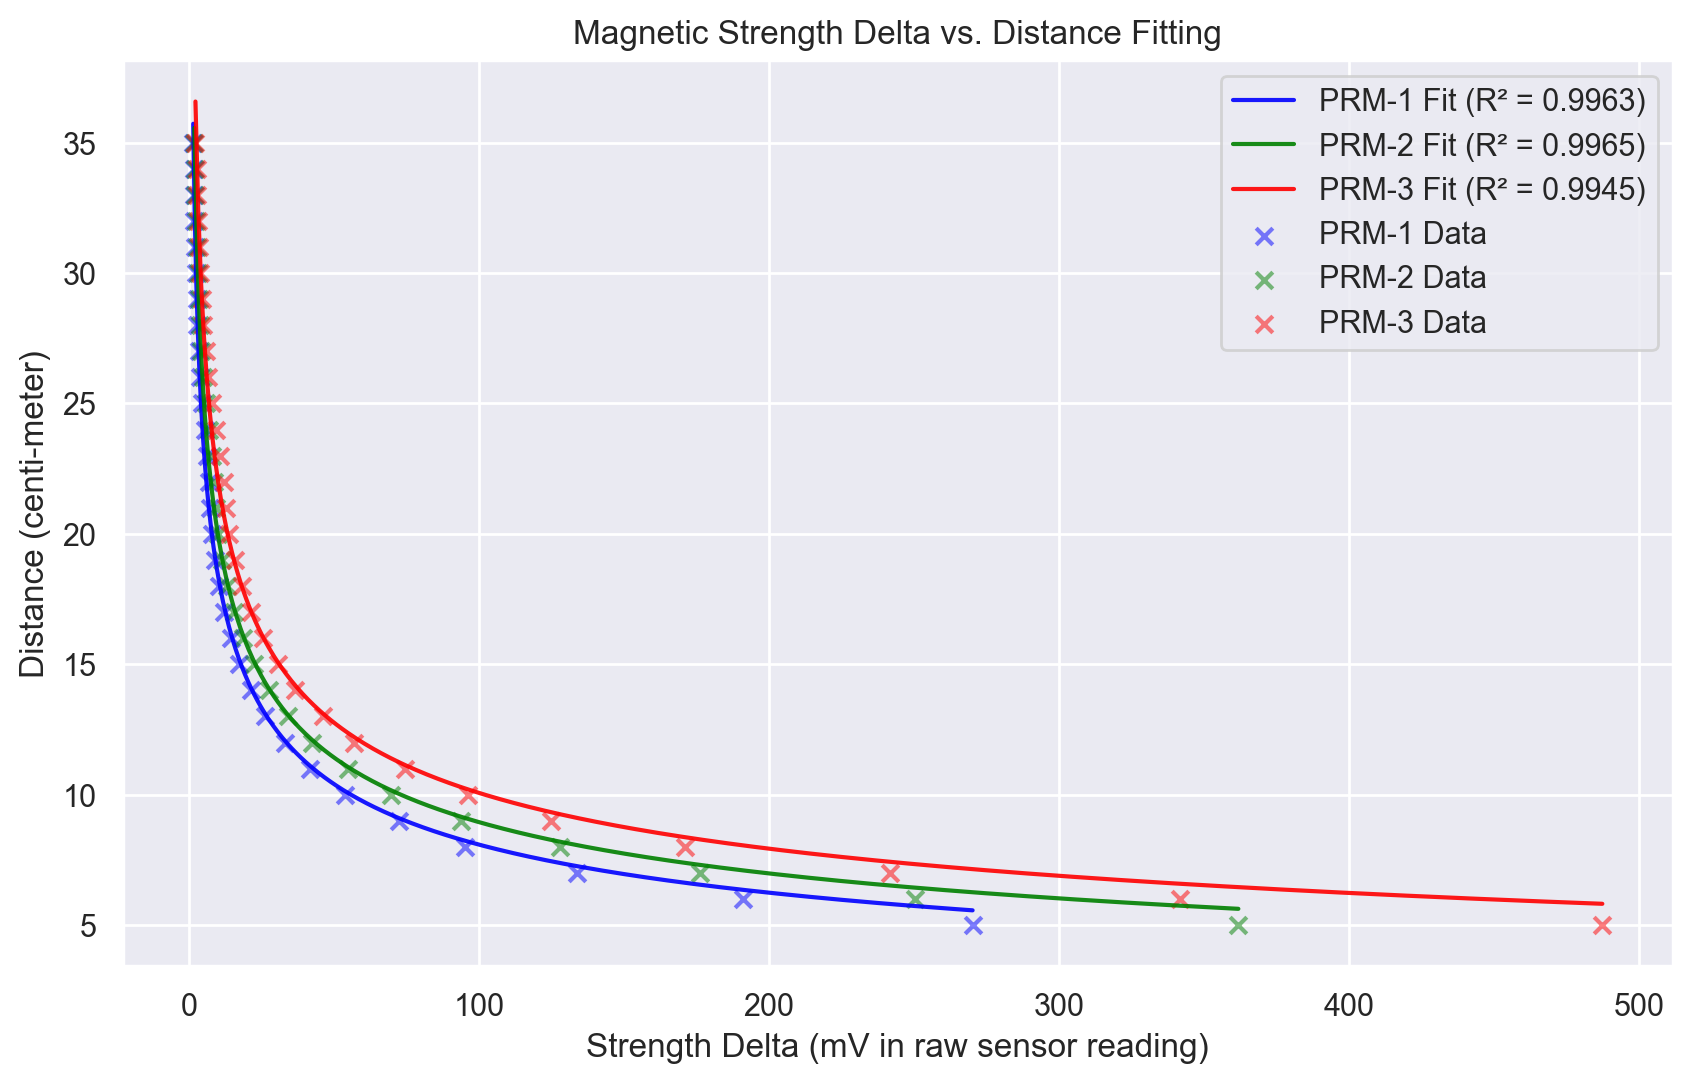

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


magnet_corr_data = pd.read_csv("./../data/mar-27-prlm-prm-prmm-strength-dist-corr-re-gather/mar-27-prm-1-1.0cm-resolution-corr-regather.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])["anchor_0"]

np.array(magnet_corr_data)
zero_indices = np.where(magnet_corr_data == 0)[0]
zero_indices
split_arrays = np.split(magnet_corr_data, zero_indices)
# 33 needs to be removed

mean_val_array = [np.mean(split_arrays[0])]
for indx in range(1, len(split_arrays)):
    if (indx != len(split_arrays) - 1):
        mean_val_array.append(np.mean(split_arrays[indx][20:]))
print(mean_val_array)

prm_1_strength_deltas = mean_val_array[1:-1] - mean_val_array[0]
prm_1_distances = np.linspace(5, 5+len(prm_1_strength_deltas)-1, len(prm_1_strength_deltas))
print(prm_1_strength_deltas)
print(prm_1_distances)
print(len(prm_1_distances) == len(prm_1_strength_deltas))

magnet_corr_data = pd.read_csv("./../data/mar-27-prlm-prm-prmm-strength-dist-corr-re-gather/mar-27-prm-2-1.0cm-resolution-corr-regather.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])["anchor_0"]

np.array(magnet_corr_data)
zero_indices = np.where(magnet_corr_data == 0)[0]
zero_indices
split_arrays = np.split(magnet_corr_data, zero_indices)
# 33 needs to be removed

mean_val_array = [np.mean(split_arrays[0])]
for indx in range(1, len(split_arrays)):
    if (indx != len(split_arrays) - 1):
        mean_val_array.append(np.mean(split_arrays[indx][20:]))
print(mean_val_array)

prm_2_strength_deltas = mean_val_array[1:-1] - mean_val_array[0]
prm_2_distances = np.linspace(5, 5+len(prm_2_strength_deltas)-1, len(prm_2_strength_deltas))
print(prm_2_strength_deltas)
print(prm_2_distances)
print(len(prm_2_distances) == len(prm_2_strength_deltas))

magnet_corr_data = pd.read_csv("./../data/mar-27-prlm-prm-prmm-strength-dist-corr-re-gather/mar-27-prm-3-1.0cm-resolution-corr-regather.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])["anchor_0"]

np.array(magnet_corr_data)
zero_indices = np.where(magnet_corr_data == 0)[0]
zero_indices
split_arrays = np.split(magnet_corr_data, zero_indices)
# 33 needs to be removed

mean_val_array = [np.mean(split_arrays[0])]
for indx in range(1, len(split_arrays)):
    if (indx != len(split_arrays) - 1):
        mean_val_array.append(np.mean(split_arrays[indx][20:]))
print(mean_val_array)

prm_3_strength_deltas = mean_val_array[1:-1] - mean_val_array[0]
prm_3_distances = np.linspace(5, 5+len(prm_3_strength_deltas)-1, len(prm_3_strength_deltas))
print(prm_3_strength_deltas)
print(prm_3_distances)
print(len(prm_3_distances) == len(prm_3_strength_deltas))

def inv_cubic_func(x, a, b):
    return a + b * x**(-1/3)

def compute_r_squared(y_true, y_pred):
    # Total sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    # Residual sum of squares
    ss_res = np.sum((y_true - y_pred) ** 2)
    # R^2 calculation
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def gather_plot_data(x_values, fit_coeffs, func):
    x_dense = np.linspace(min(x_values), max(x_values), 500)
    y_dense = func(x_dense, *fit_coeffs)
    return x_dense, y_dense

# Assuming the below variables are predefined and contain the appropriate data:
# prlm_strength_deltas, prm_strength_deltas, prmm_strength_deltas
# prlm_distances, prm_distances, prmm_distances

prm_1_coeffs, _ = curve_fit(inv_cubic_func, prm_1_strength_deltas, prm_1_distances)
prm_2_coeffs, _ = curve_fit(inv_cubic_func, prm_2_strength_deltas, prm_2_distances)
prm_3_coeffs, _ = curve_fit(inv_cubic_func, prm_3_strength_deltas, prm_3_distances)

prm_1_x_dense, prm_1_y_dense = gather_plot_data(prm_1_strength_deltas, prm_1_coeffs, inv_cubic_func)
prm_2_x_dense, prm_2_y_dense = gather_plot_data(prm_2_strength_deltas, prm_2_coeffs, inv_cubic_func)
prm_3_x_dense, prm_3_y_dense = gather_plot_data(prm_3_strength_deltas, prm_3_coeffs, inv_cubic_func)

original_data_array = [(prm_1_strength_deltas, prm_1_distances), 
                       (prm_2_strength_deltas, prm_2_distances), 
                       (prm_3_strength_deltas, prm_3_distances)]

y_predicted_array = [inv_cubic_func(prm_1_strength_deltas, *prm_1_coeffs), 
                     inv_cubic_func(prm_2_strength_deltas, *prm_2_coeffs), 
                     inv_cubic_func(prm_3_strength_deltas, *prm_3_coeffs)]


plot_data_array = [(prm_1_x_dense, prm_1_y_dense), 
                   (prm_2_x_dense, prm_2_y_dense), 
                   (prm_3_x_dense, prm_3_y_dense)]


data_name_array = ["PRM-1", "PRM-2", "PRM-3"]

colors = ['blue', 'green', 'red']  # Different colors for different magnets

plt.figure(figsize=(10, 6), dpi=200)  # Set the figure size

for i, color in zip(range(len(data_name_array)), colors):
    # Calculate R^2 for each dataset
    r_squared = compute_r_squared(original_data_array[i][1], y_predicted_array[i])
    # Plot the original data as scatter plots
    plt.scatter(original_data_array[i][0], original_data_array[i][1], color=color, marker="x", alpha=0.5, label=f'{data_name_array[i]} Data')
    # Plot the fitting curves
    plt.plot(plot_data_array[i][0], plot_data_array[i][1], color=color, alpha=0.9, label=f'{data_name_array[i]} Fit (R² = {r_squared:.4f})')

plt.xlabel('Strength Delta (mV in raw sensor reading)')  # Set the x-axis label
plt.ylabel('Distance (centi-meter)')  # Set the y-axis label
plt.title('Magnetic Strength Delta vs. Distance Fitting')  # Set the title
plt.legend()  # Show the legend
plt.grid(True)  # Enable the grid for easier visualization
plt.show()  # Display the plot


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit




def inv_cubic_func(x, a, b):
    return b * x**(1/3)

prlm_data = pd.read_csv("./../data/mar-27-prlm-prm-prmm-strength-dist-corr-re-gather/mar-27-prlm-1-1.0cm-resolution-corr-regather.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])["anchor_0"]
prm_data = pd.read_csv("./../data/mar-27-prlm-prm-prmm-strength-dist-corr-re-gather/mar-27-prm-1-1.0cm-resolution-corr-regather.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])["anchor_0"]
prmm_data = pd.read_csv("./../data/mar-27-prlm-prm-prmm-strength-dist-corr-re-gather/mar-27-prmm-1-1.0cm-resolution-corr-regather.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])["anchor_0"]




### Comparative Analysis of Different Mathematical Models on Magnet Correlation Data

This script performs a comprehensive comparative analysis of several mathematical models on magnetic correlation data. It applies natural logarithmic, inverse, inverse square, and inverse cubic functions to fit the data of PRLM magnet correlation, illustrating how different models capture the underlying trends in magnet-sensor interactions.

#### Function Definitions:
- **log_func**: Fits data to a natural logarithmic model.
- **inverse_func**: Uses an inverse linear model.
- **inv_square_func**: Fits data using an inverse square model.
- **inv_cubic_func**: Applies an inverse cubic model.

#### Core Operations:
1. **Data Loading**: Retrieves magnetic correlation data from a file.
2. **Data Splitting**: Identifies and handles zero indices to split the dataset accordingly.
3. **Model Fitting**: Each mathematical model is fitted to the data, and R² values are calculated to assess fit quality.
4. **Piece-wise Fitting**: Employs a two-piece logarithmic fitting for specific segments defined by a threshold.

#### Plotting:
- Displays scatter plots of the raw data.
- Visualizes each fitted model with distinct colors and labels.
- Enhances plot readability with labels, legends, and a grid.

#### Example Usage:
```python
x_values, y_values = analyze_magnet_correlation("./../data/mar-27-prlm-prm-prmm-strength-dist-corr-re-gather/mar-27-prlm-1-1.0cm-resolution-corr-regather.txt", magnet_type='PRLM')
fit_results = piece_wise_fit(21.667, x_values, y_values, log_func)
print(fit_results)


/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


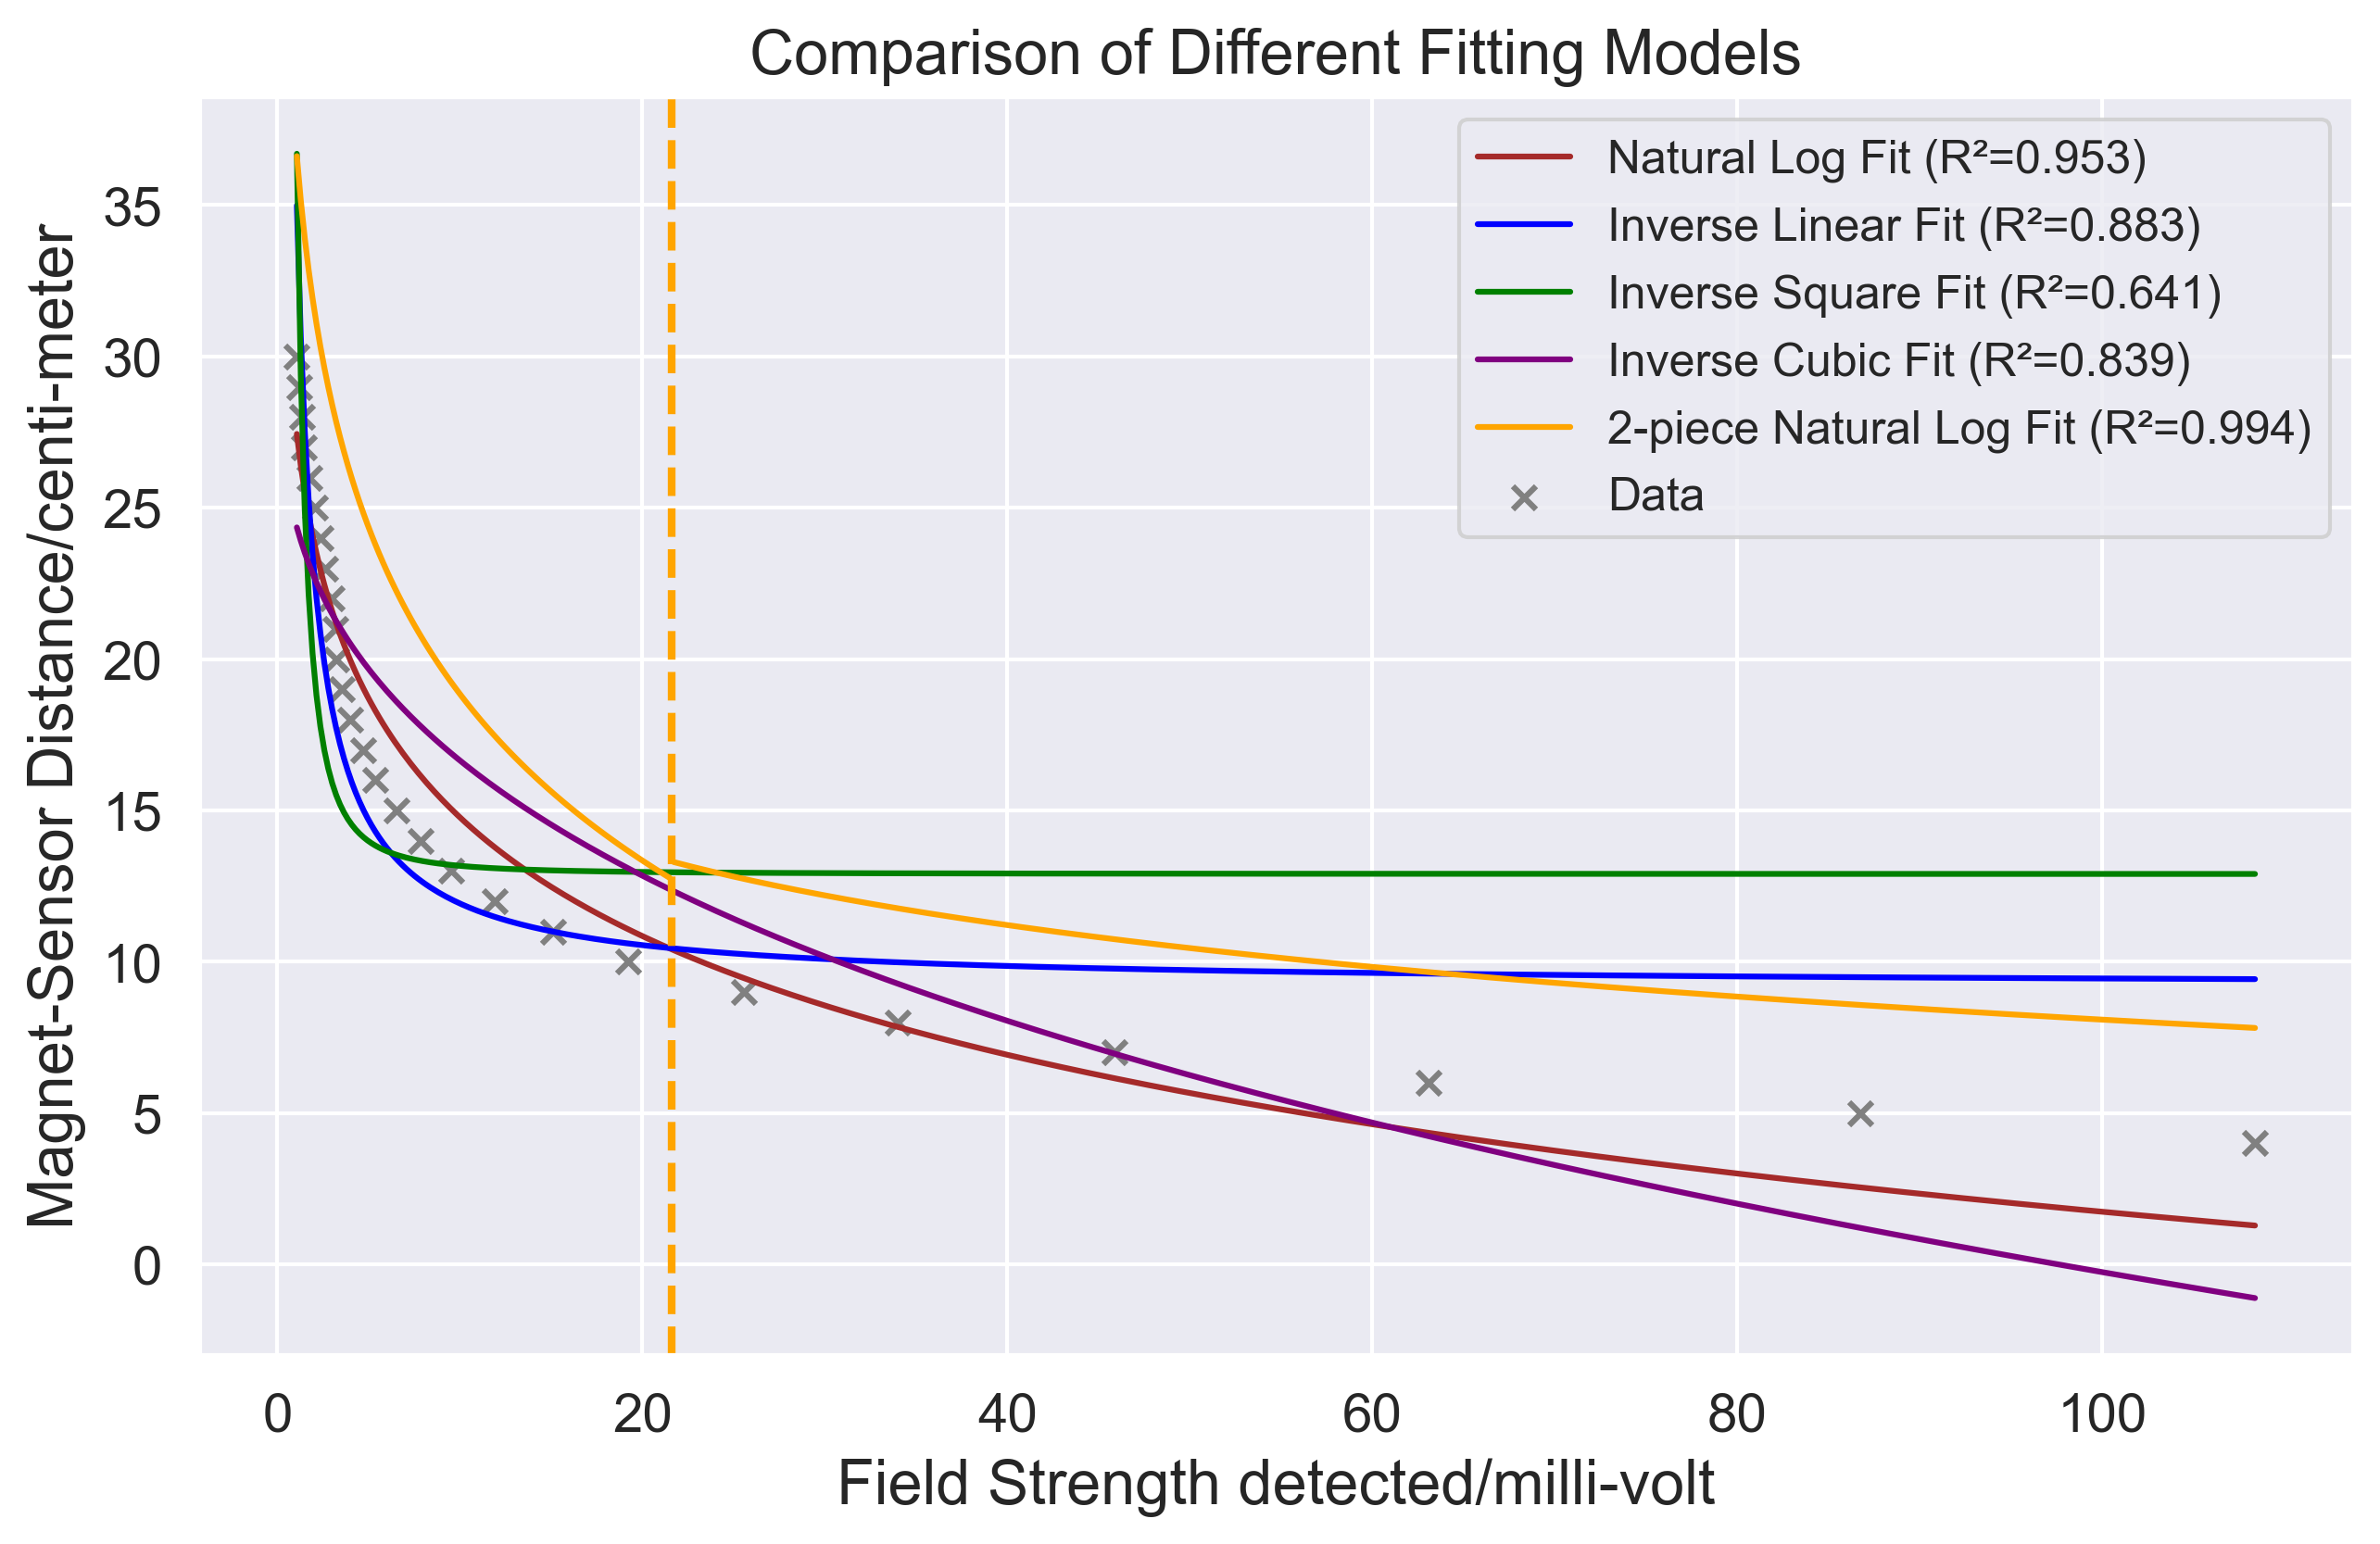

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

x_values, y_values = analyze_magnet_correlation("./../data/mar-27-prlm-prm-prmm-strength-dist-corr-re-gather/mar-27-prlm-1-1.0cm-resolution-corr-regather.txt", magnet_type='PRLM')



def piece_wise_fit(threshold, x_values, y_values, func, ):
    below_threshold = x_values < threshold
    above_threshold = x_values >= threshold

    x_below = x_values[below_threshold]
    y_below = y_values[below_threshold]
    x_above = x_values[above_threshold]
    y_above = y_values[above_threshold]

    popt_below_best, _ = curve_fit(log_func, x_below, y_below)
    popt_above_best, _ = curve_fit(log_func, x_above, y_above)


    return popt_below_best, popt_above_best



# Define the fitting functions
def log_func(x, a, b, c):
    return a + b * np.log(x) + c

def inverse_func(x, a, b):
    return a + b / x

def inv_square_func(x, a, b):
    return a + b * x**-2

def inv_cubic_func(x, a, b):
    return a + b * x**(1/3)

# Define a function to compute R-squared
def compute_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

# Sample data (replace with your actual data)
# x_values = np.linspace(1, 100, 50)  # Ensure no zero values for log and inverse operations
# y_values = 3 * np.log(x_values) + np.random.normal(size=50, scale=0.5)  # Example dependent on log(x)

# Perform curve fitting
popt_log, _ = curve_fit(log_func, x_values, y_values)
popt_inverse, _ = curve_fit(inverse_func, x_values, y_values)
popt_inv_square, _ = curve_fit(inv_square_func, x_values, y_values)
popt_inv_cubic, _ = curve_fit(inv_cubic_func, x_values, y_values)


prm_1_profile = [(179.24, -7.94, -142.11), (22.79, -3.41, 1.0), 21.667]
# Generate dense x-values for smooth curve plotting
x_dense = np.linspace(min(x_values), max(x_values), 500)

# Predict y-values using the fitted models
y_pred_log = log_func(x_dense, *popt_log)
y_pred_inverse = inverse_func(x_dense, *popt_inverse)
y_pred_inv_square = inv_square_func(x_dense, *popt_inv_square)
y_pred_inv_cubic = inv_cubic_func(x_dense, *popt_inv_cubic)

x_fit_below = x_dense < 21.667
x_fit_above = x_dense >= 21.667

x_fit_below_values = x_dense[x_fit_below]  # Get the x values where x_dense < 21.667
x_fit_above_values = x_dense[x_fit_above]  # Get the x values where x_dense >= 21.667


y_fit_below = log_func(x_fit_below_values, 179.24, -7.94, -142.11)

y_fit_above = log_func(x_fit_above_values, 22.79, -3.41, 1.0)

# Calculate R-squared for each model
r_squared_log = compute_r_squared(y_values, log_func(x_values, *popt_log))
r_squared_inverse = compute_r_squared(y_values, inverse_func(x_values, *popt_inverse))
r_squared_inv_square = compute_r_squared(y_values, inv_square_func(x_values, *popt_inv_square))
r_squared_inv_cubic = compute_r_squared(y_values, inv_cubic_func(x_values, *popt_inv_cubic))

# Plotting all fits
plt.figure(figsize=(10, 6), dpi=300)
plt.scatter(x_values, y_values, color='grey', label='Data', marker="x")
plt.plot(x_dense, y_pred_log, label=f'Natural Log Fit (R²={r_squared_log:.3f})', color='brown')
plt.plot(x_dense, y_pred_inverse, label=f'Inverse Linear Fit (R²={r_squared_inverse:.3f})', color='blue')
plt.plot(x_dense, y_pred_inv_square, label=f'Inverse Square Fit (R²={r_squared_inv_square:.3f})', color='green')
plt.plot(x_dense, y_pred_inv_cubic, label=f'Inverse Cubic Fit (R²={r_squared_inv_cubic:.3f})', color='purple')

# Plotting the logarithmic fit function for data below the threshold
plt.plot(x_fit_below_values, y_fit_below, color='orange', label=f'2-piece Natural Log Fit (R²=0.994)',)

# Plotting the logarithmic fit function for data above the threshold
plt.plot(x_fit_above_values, y_fit_above, color='orange', )

# Plot the vertical line at x = 80 mV for the separation
plt.axvline(x=21.6, color='orange', linestyle='--', linewidth=2, )

plt.title('Comparison of Different Fitting Models', fontsize=16,)
plt.xlabel('Field Strength detected/milli-volt', fontsize=16)
plt.ylabel('Magnet-Sensor Distance/centi-meter', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)  # Enlarge major tick labels
plt.tick_params(axis='both', which='minor', labelsize=14)  # Enlarge minor tick labels if used

plt.legend(fontsize=12)
plt.grid(True)
plt.show()


### Threshold Analysis for Multiple Functions

This function, `analyze_thresholds`, is designed to optimize curve fitting across two segments of data, divided at various potential thresholds. It explores combinations of four different mathematical functions to model segments above and below each threshold, aiming to maximize the average R² value for the best fit.

#### Overview:
- **Functions**: Includes inverse, inverse square, inverse cubic, and logarithmic functions.
- **Threshold Selection**: Iterates over potential thresholds determined by `step_size` within the `x_values` data range.
- **Curve Fitting**: Fits both segments with all combinations of the specified functions.
- **Performance Evaluation**: Calculates the R² value for fittings above and below each threshold, seeking to maximize the average R².

#### Steps Involved:
1. **Initialize Variables**: Set up lists for function types and labels.
2. **Threshold Iteration**: Loop through potential thresholds.
3. **Segmentation**: Divide the data at each threshold.
4. **Function Combination Testing**: Apply each function combination to the data segments.
5. **Fit Quality Check**: Ensure a minimum number of data points for a reliable fit.
6. **Error Handling**: Catch and log errors during fitting.
7. **Result Compilation**: Store and return the best fitting results for each function combination.

#### Example Usage:
This can be particularly useful in scientific data analysis where segment-wise modeling is required to understand different behavioral phases in experimental data.

```python
# Assuming x_values and y_values are your data arrays and step_size determines the granularity of threshold testing
results = analyze_thresholds(x_values, y_values, step_size)
for combination, result in results.items():
    print(f"{combination}: Best Threshold = {result['Threshold']}, Best Average R² = {result['Average R²']}")


In [770]:
# Function to perform the analysis ensuring a minimum number of data points
def analyze_thresholds(x_values, y_values, step_size):
    functions = [inverse_func, inv_square_func, inv_cubic_func, log_func]
    labels = ['F1', 'F2', 'F3', 'F4']
    threshold_indices = range(0, len(x_values), step_size)
    best_results = {}

    for i, func_below in enumerate(functions):
        for j, func_above in enumerate(functions):
            combination_label = labels[i] + '+' + labels[j]
            best_r2 = -np.inf  # Initialize with very low R²
            best_threshold = None

            for threshold_index in threshold_indices:
                threshold = x_values[threshold_index]
                below_threshold = x_values < threshold
                above_threshold = x_values >= threshold

                x_below = x_values[below_threshold]
                y_below = y_values[below_threshold]
                x_above = x_values[above_threshold]
                y_above = y_values[above_threshold]

                if len(x_below) >= 3 and len(x_above) >= 3:
                    try:
                        popt_below, _ = curve_fit(func_below, x_below, y_below)
                        y_pred_below = func_below(x_below, *popt_below)
                        r2_below = r2_score(y_below, y_pred_below)

                        popt_above, _ = curve_fit(func_above, x_above, y_above)
                        y_pred_above = func_above(x_above, *popt_above)
                        r2_above = r2_score(y_above, y_pred_above)

                        avg_r2 = (r2_below + r2_above) / 2
                        if avg_r2 > best_r2:
                            best_r2 = avg_r2
                            best_threshold = threshold

                    except Exception as e:
                        print(f"Fit error at threshold {threshold} with functions {func_below.__name__} and {func_above.__name__}: {str(e)}")
                else:
                    print(f"Not enough data points below or above threshold {threshold} for functions {func_below.__name__} and {func_above.__name__}")

            # Store the best results for the current combination
            best_results[combination_label] = {'Threshold': best_threshold, 'Average R²': best_r2}

    return best_results

# Example usage:
# x_values = np.array([...])
# y_values = np.array([...])
# step_size = 5
# results = analyze_thresholds(x_values, y_values, step_size)
# for combination, result in results.items():
#     print(f"{combination}: Best Threshold = {result['Threshold']}, Best Average R² = {result['Average R²']}")

In [771]:
analyze_thresholds(x_values, y_values, step_size=5)

Not enough data points below or above threshold 270.20288768487444 for functions inverse_func and inverse_func
Not enough data points below or above threshold 1.4570141162466825 for functions inverse_func and inverse_func
Not enough data points below or above threshold 270.20288768487444 for functions inverse_func and inv_square_func
Not enough data points below or above threshold 1.4570141162466825 for functions inverse_func and inv_square_func
Not enough data points below or above threshold 270.20288768487444 for functions inverse_func and inv_cubic_func
Not enough data points below or above threshold 1.4570141162466825 for functions inverse_func and inv_cubic_func
Not enough data points below or above threshold 270.20288768487444 for functions inverse_func and log_func
Fit error at threshold 53.831056743697445 with functions inverse_func and log_func: Covariance of the parameters could not be estimated
Fit error at threshold 17.396342822129554 with functions inverse_func and log_fun

{'F1+F1': {'Threshold': 4.5534831946783925, 'Average R²': 0.9614156577877971},
 'F1+F2': {'Threshold': 53.831056743697445, 'Average R²': 0.8863830609981846},
 'F1+F3': {'Threshold': 53.831056743697445, 'Average R²': 0.8321282209638156},
 'F1+F4': {'Threshold': 2.3914839789922553, 'Average R²': 0.9709927418922675},
 'F2+F1': {'Threshold': 4.5534831946783925, 'Average R²': 0.9432189340163345},
 'F2+F2': {'Threshold': 4.5534831946783925, 'Average R²': 0.8466221779714738},
 'F2+F3': {'Threshold': 4.5534831946783925, 'Average R²': 0.7624663172377588},
 'F2+F4': {'Threshold': 2.3914839789922553, 'Average R²': 0.9726883140948427},
 'F3+F1': {'Threshold': 2.3914839789922553, 'Average R²': 0.9281729329185737},
 'F3+F2': {'Threshold': 4.5534831946783925, 'Average R²': 0.8193352140437973},
 'F3+F3': {'Threshold': 2.3914839789922553, 'Average R²': 0.7375932697022406},
 'F3+F4': {'Threshold': 2.3914839789922553, 'Average R²': 0.9704931894644222},
 'F4+F1': {'Threshold': 53.831056743697445, 'Average

### Design algorithm for the detection

Multilateration involves finding the position of a point based on known distances to several other points (in this case, for simplicity, two points). The fundamental principle used here is the geometric fact that the distance between two points can be described by the equation of a circle (in 2D):

$$ (x - x_i)^2 + (y - y_i)^2 = d_i^2 $$

Where $(x, y)$ is the unknown point, $(x_i, y_i)$ is a known point, and $d_i$ is the distance from the unknown point to the known point.

If you expand this equation, you get:

$$ x^2 - 2xx_i + x_i^2 + y^2 - 2yy_i + y_i^2 = d_i^2 $$

To simplify the equations and make them linear, we can subtract one circle's equation from another. This subtraction eliminates the $x^2$ and $y^2$ terms, which are the same for all equations. Doing this for two points, we get a system of linear equations:

$$ -2xx_1 + x_1^2 -2yy_1 + y_1^2 - (-2xx_2 + x_2^2 - 2yy_2 + y_2^2) = d_1^2 - d_2^2 $$

Rearranging terms and simplifying, we get:

$$ 2(x_2 - x_1)x + 2(y_2 - y_1)y = d_1^2 - d_2^2 + x_2^2 - x_1^2 + y_2^2 - y_1^2 $$

This is now a linear equation in terms of $x$ and $y$ (the coordinates of the unknown point), which we can write as:

$$ A \cdot x = b $$

Here, $A$ is the matrix of coefficients, $x$ is the vector containing the unknowns $x$ and $y$, and $b$ is the constant vector.




Matrix \( A \) will contain the coefficients for \( x \) and \( y \) from the linear equations:

$$
A = \begin{bmatrix}
2(x_2 - x_1) & 2(y_2 - y_1) \\
2(x_3 - x_1) & 2(y_3 - y_1)
\end{bmatrix}
$$

Vector \( B \) will contain the constants from the right side of the linear equations:

$$
B = \begin{bmatrix}
d_2^2 - d_1^2 - x_2^2 - y_2^2 + x_1^2 + y_1^2 \\
d_3^2 - d_1^2 - x_3^2 - y_3^2 + x_1^2 + y_1^2
\end{bmatrix}
$$

The unknown vector \( X \) is:

$$
X = \begin{bmatrix}
x \\
y
\end{bmatrix}
$$

This system can be solved using a least squares approach if the equations are independent (which they should be if the three known points are not collinear). If there are more than three points, \( A \) will have more rows, one for each additional point, and \( B \) will have corresponding additional elements, making the system over-determined. In such cases, the least squares solution will minimize the sum of squared residuals.


To solve for $x$, we would normally use matrix inverse or some other direct method, but because we are solving via least squares (which accounts for potential measurement errors and over-determined systems), we use `np.linalg.lstsq`. This function will find the vector $x$ that minimizes the residual sum of squares between the observed outcomes in $b$ and the outcomes predicted by the linear approximation defined by $A$.

In [ ]:
def calculate_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    Args:
    point1 (array-like): The coordinates of the first point (x, y).
    point2 (array-like): The coordinates of the second point (x, y).

    Returns:
    float: The Euclidean distance between the two points.
    """
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [31]:
def compute_distance(strength_val, below_corr, above_corr, threshold_division):
    """
    Computes the distance from a sensor to a magnet based on the magnet's field strength.

    This function uses a piecewise logarithmic function to convert the field strength 
    measured in millivolts to a distance. Different parameters are used for the logarithmic 
    function depending on whether the field strength is above or below a specified threshold. 
    This accounts for potential non-linearity in the sensor's response at different field strengths.

    Args:
        strength_val (float): The field strength of the magnet measured in millivolts.

    Returns:
        float: The estimated distance from the sensor to the magnet.
    """
    # print(below_corr)
    # print(above_corr)
    (a_below_best, b_below_best, c_below_best) = below_corr
    (a_above_best, b_above_best, c_above_best) = above_corr

    # Check if the field strength is below the threshold.
    # If so, use the logarithmic function parameters for values below the threshold.
    if strength_val < threshold_division:
        return log_func(strength_val, a_below_best, b_below_best, c_below_best)

    # If the field strength is above the threshold,
    # use the logarithmic function parameters for values above the threshold.
    elif strength_val >= threshold_division:
        return log_func(strength_val, a_above_best, b_above_best, c_above_best)

#### All magnet profiles

* PRLM-1:
    * 1.0cm resolution: [(-110.77590098097235, -8.643075277236452, 141.4774630824354), (-250.7193202210314, -3.6829848225262793, 271.891114221628), 7]
* PRM-1: 
    * 0.5cm resolution: [(181.92, -6.8, -147.93), (333.43, -3.41, -309.46), 20]   => residual error: 2.6800 1.7700 => 2-norm distance: ~1.05cm
    * 1.0cm resolution: [(-17.96, -6.11, 51.62), (-392.27, -2.20, 411.23), 51.67] => residual error: 0.1812 0.0226 => 2-norm distance: ~1.33cm
    * 1.0cm re-gathering: [(179.24, -7.94, -142.11), (22.79, -3.41, 1.0), 21.667]
* PRM-2:
    * 1.0cm resolution: [(197.32, -7.63, -158.86), (-341.75, -3.25, 365.68), 34.167]

* PRMM-1: 
    * 1.0cm resolution-1st trial: [(291.41, -8.74, -235.86), (442.58, -3.71, -409.98), 80.0] => residual error: 897.2895 919.9117 => 2-norm distance: ~4.46cm



### Trilateration-Based Localization Function

This function implements a naive localization technique using Trilateration, combining multiple anchor readings to estimate the position of a magnetic object. It primarily targets scenarios with varied magnetic types and sensor configurations.

#### Function Overview:
- **Input Parameters**:
  - **Anchor_position_ls**: A list of tuples representing the (x, y) coordinates of each anchor.
  - **Anchor_reading_ls**: Corresponding sensory readings from each anchor, matched in order with `Anchor_position_ls`.
  - **cur_indx**: Current index or timestamp for logging.
  - **place_or_remove**: Describes the action (either placing or removing the magnet).

#### Key Features:
- Utilizes logarithmic functions predefined for each magnet type to convert sensor readings into distances.
- Employs Euclidean distance calculations for error assessment and position estimation.
- Implements least squares regression to solve for the most probable magnet location given the distances and anchor positions.

#### Error Handling:
- Ensures a minimum of three anchor points are provided.
- Checks for consistent lengths between anchor positions and readings.
- Defaults to returning `-1` for abnormal cases where requirements aren't met.

#### Return Structure:
- Returns a dictionary with keys for each magnet type evaluated, containing:
  - Predicted x and y coordinates.
  - Predicted distances from each anchor.
  - Observed distances calculated from sensor readings.
  - Computed residual error indicating the accuracy of the prediction.

#### Example Usage:
```python
# Define anchor positions and readings
anchor_positions = [(0, 0), (1, 0), (0, 1)]
anchor_readings = [0.5, 0.7, 0.6]
current_index = 10
action = 'place'

# Call the localize function
results = localize(anchor_positions, anchor_readings, current_index, action)
print(results)


In [27]:
# Log Fit: y = -155.86 + -8.53 * ln(x) + 197.36
# Log Fit: y = -333.70 + -3.46 * ln(x) + 359.18
# 25.8333333

def localize(Anchor_position_ls, Anchor_reading_ls, cur_indx, place_or_remove):
    """
    Function to carry out naive localization technique utilizing Trilateration for multiple anchors.

    Args: 
        Anchor_position_ls: List of tuples with all anchor positions in order (x, y).
        Anchor_reading_ls: List of all sensory values from all anchor points(sensors), order in accordance to Anchor_position_ls.

    Returns:
        to_return: normal or abnormal case analysis
            normal: Estimated position (point: {x, y}) representing the position of the magnet.
            abnormal: -1 
    """
    # "PRM": [(-17.96, -6.11, 51.62), (-392.27, -2.20, 411.23), 51.67]
    # "PRLM-1": [(-107.59, -8.79, 138.39), (265.52, -3.78, -243.97), 6],
    magnet_profiles = {
                       "PRLM-1": prlm_1_profile,
        
                       "PRM-1": prm_1_profile, 
#                        "PRM-2": prm_2_profile,
#                        "PRM-3": prm_3_profile,
#                        "PRM-4": prm_4_profile,
#                        "PRM-5": prm_5_profile,
#                        "PRM-6": prm_6_profile,

                       "PRMM-1": prmm_1_profile}
#     }

    # Define the logarithmic function
    def log_func(x, a, b, c):
        return a + b * np.log(x) + c
    
    def euclidean_dist(point1, point2):
        difference = np.array(point1) - np.array(point2)
        distance = np.sqrt(np.sum(difference ** 2))
        return distance

    # sensor position list need to be ordered same as estimated distances list
    def compute_residual_error(predicted_location, sensor_positions, observation_distances):
        
        
        
        estimation_distance = []
        for sensor_position in sensor_positions:
            estimation_distance.append(euclidean_dist(predicted_location, sensor_position))
            
#         print(f"estimation_distances: {estimation_distance}")
#         print(f"observation_distances: {observation_distances}")
        
                                      
        residual_error = sum((euclidean_dist(predicted_location, sensor_position) - observation_distances) ** 2
                             for sensor_position, observation_distances in zip(sensor_positions, observation_distances))
        return residual_error

    # default return is abnormal
    to_return = -1
    
    # initialize an error dictionary for storing distance comparison residual error,
    # formatted as {"magnet_type": (predicted_position, prediction_residual)}
    prediction_result_dict = {"timestamp": cur_indx, "action": place_or_remove}

    # Ensure there are at least three anchors &&
    # Ensure the length of anchor position list equals to the length of anchor reading list
    if len(Anchor_position_ls) < 3 or len(Anchor_position_ls) != len(Anchor_reading_ls): return to_return

    # Successfully go into the evaluation process
    # pull out all magnets info
    magnet_names = magnet_profiles.keys()

    # loop through all magnet profiles
    for each_magnet in magnet_names:
        # Convert sensor readings to distances
        distances = [compute_distance(reading, magnet_profiles[each_magnet][0], magnet_profiles[each_magnet][1], magnet_profiles[each_magnet][2]) for reading in Anchor_reading_ls]
        # distances = [24, 30, 23, ]
        # Reference anchor (typically the first one)
        ref_anchor = Anchor_position_ls[0]
        ref_dist = distances[0]

        # Construct the Matrix A and vector b
        rows_A = []
        vec_b = []
        for i in range(1, len(Anchor_position_ls)):
            anchor = Anchor_position_ls[i]
            dist = distances[i]
            row = [2 * (anchor[0] - ref_anchor[0]), 2 * (anchor[1] - ref_anchor[1])]
            rows_A.append(row)
            b_value = dist**2 - ref_dist**2 - anchor[0]**2 - anchor[1]**2 + ref_anchor[0]**2 + ref_anchor[1]**2
            vec_b.append(b_value)

        mat_A = np.array(rows_A)
        vec_b = np.array(vec_b)

        # Do the least square solution
        # position, residuals = sp.optimize.nnls(mat_A, vec_b)
        position, residuals, _, _ = la.lstsq(mat_A, vec_b)
        position = -position
        # compute the estimation error
        residual_err = compute_residual_error(position, Anchor_position_ls, distances)
        
        # store the predicted position and corresponding residuals into the prediction_result_dict
        prediction_result_dict[each_magnet + "/pos-x"] = position[0]
        prediction_result_dict[each_magnet + "/pos-y"] = position[1]
        prediction_result_dict[each_magnet + "/predicted-distance"] = np.round(np.array([euclidean_dist(anchor_pos, position) for anchor_pos in Anchor_position_ls]), 4)
        prediction_result_dict[each_magnet + "/observed-distance"] = np.round(np.array(distances), 4)
        prediction_result_dict[each_magnet + "/err"] = residual_err
        
        
#         print(f"If Type == '{each_magnet}' \n\tPredicted Position: {position} \n\tResidual Error: {residual_err}")
        
        
        


    # Return the solution or abnormal case
    return prediction_result_dict


### Plotting Piecewise Logarithmic Functions

This Python script visualizes piecewise logarithmic functions, which are useful for analyzing field strength versus distance relationships for different materials or sensors. The script utilizes matplotlib for plotting and scipy for function fitting.

#### Functionality:
- **Logarithmic Function Definition**: Defines a logarithmic function `log_func` used for curve fitting.
- **Piecewise Function Plotting**: Implements a function to plot multiple piecewise logarithmic models, based on parameter sets provided for each segment of the model.
- **Flexible Data Input**: The plotting function takes a list where each element represents a distinct piecewise model with parameters and threshold values for segmentation.

#### Key Components:
- **log_func**: Calculates the logarithmic relationship given parameters `a`, `b`, and `c`.
- **plot_piecewise_log_functions**: Takes structured data inputs to plot multiple models on the same graph for comparative analysis.
  - **Parameters**:
    - `data`: A list where each element is another list containing a descriptive name, two sets of [a, b, c] parameters for logarithmic fitting before and after a threshold, and the threshold value itself.

#### Example of Usage:
```python
data_profiles = [
    ['Sensor A', ([1, 0.5, -10], [1, -0.5, 10], 100)],
    ['Sensor B', ([1, 0.3, -5], [1, -0.3, 15], 120)]
]

plot_piecewise_log_functions(data_profiles)


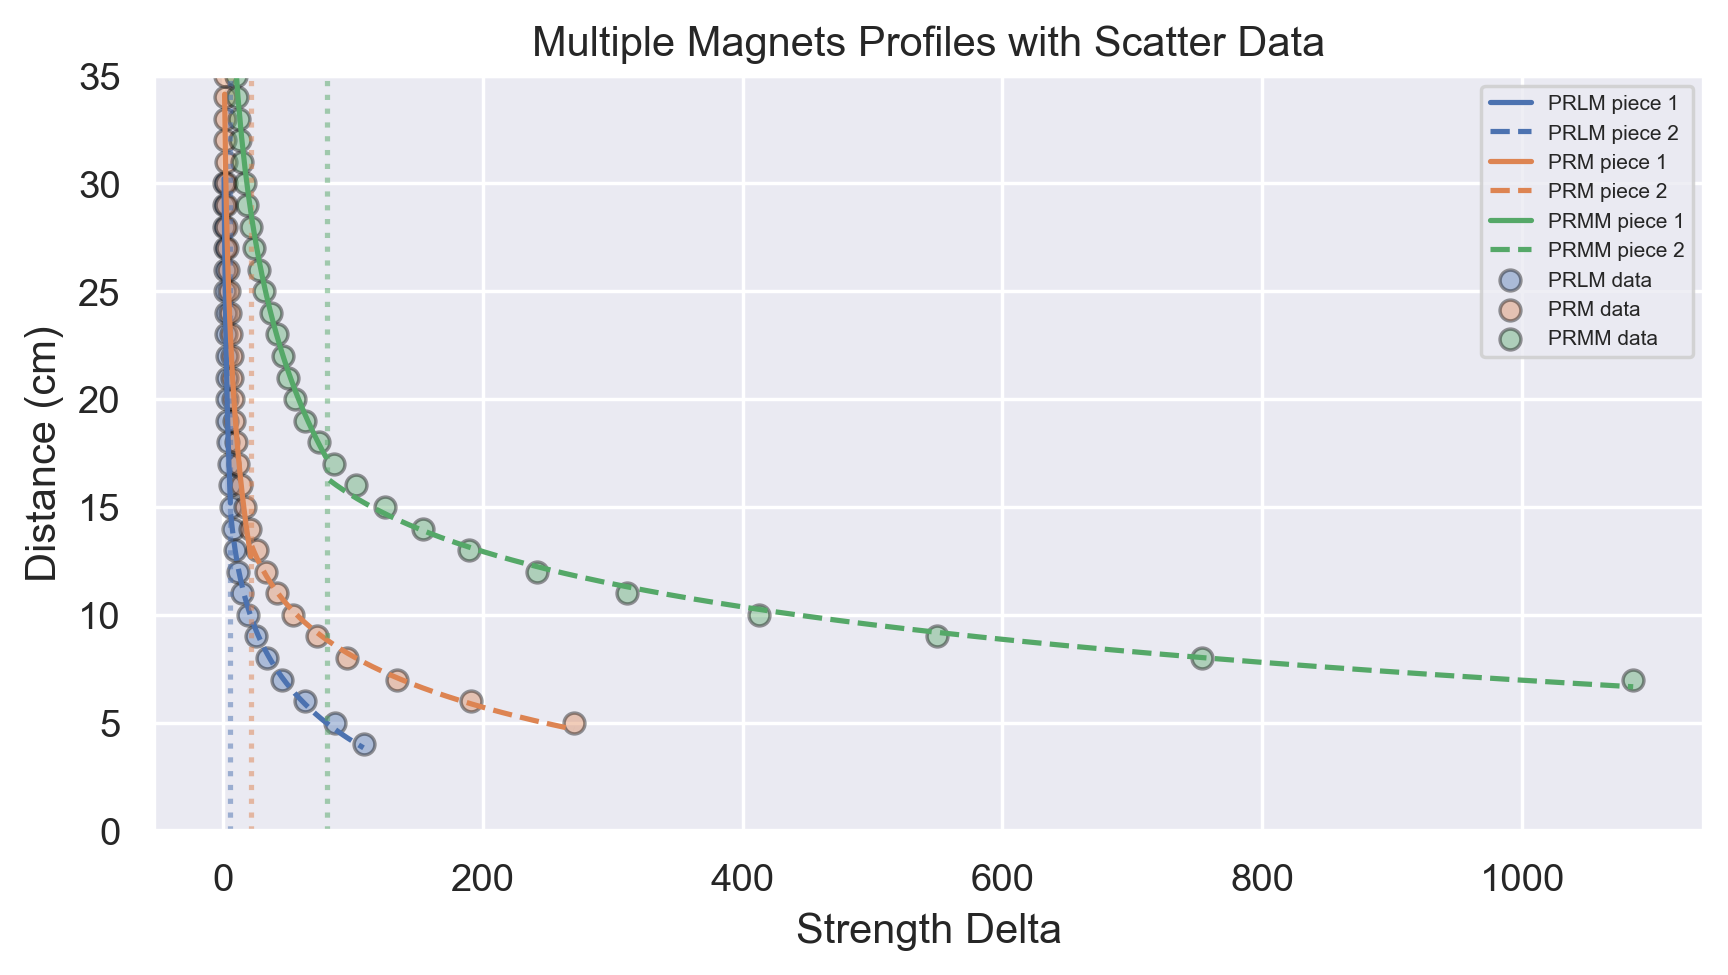

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit



prlm_1_profile = [(-107.59, -8.79, 138.39), (265.52, -3.78, -243.97), 6]
prm_1_profile = [(179.24, -7.94, -142.11), (22.79, -3.41, 1.0), 21.667]
prm_2_profile = [(197.32, -7.63, -158.86), (-341.75, -3.25, 365.68), 34.167]
prm_3_profile = [(214.98651742257684, -7.498351162532263, -174.54408685144608), (-361.6883696784114, -3.250833230970385, 386.60517953870726), 46.666666666666664]
prm_4_profile = [(-155.8608982234551, -8.532071158012691, 197.35803656673608), (-333.69861387723734, -3.4619469422876747, 359.1839360163904), 26.0]
prm_5_profile = [(-167.04803688932228, -8.006662718960483, 208.3885727606311), (-348.04534273430477, -3.409435688846302, 373.5612903566679), 35.33333333333333]
prm_6_profile = [(207.2712232534118, -7.967425741375843, -166.16626882372043), (373.1220853656233, -3.4096835938461902, -347.6268404634702), 35.33333333333333]
prmm_1_profile = [(291.41, -8.74, -235.86), (442.58, -3.71, -409.98), 80.0]

def log_func(x, a, b, c):
    """ Logarithmic fitting function. """
    return a + b * np.log(x) + c

def plot_piecewise_log_functions(data, scatter_data):
    """
    Plots multiple piecewise logarithmic functions and scatter data for magnet simulations.
    
    Parameters:
    - data: List of lists, where each inner list contains a variable name as a string,
            followed by two tuples of [a, b, c] parameters for the piecewise function,
            and a threshold value.
    - scatter_data: List of tuples, each containing arrays of strength deltas and distances.
                    The order corresponds to the order of data input.
    """
    
    plt.figure(dpi=250, figsize=(8, 4))  # Adjust figure size and DPI as needed

    for i, (profile_ls, (strengths, distances)) in enumerate(zip(data, scatter_data)):
        # Unpack the variable name, parameter sets, and threshold from the list
        variable_name = profile_ls[0]
        params1, params2, threshold = profile_ls[1][0], profile_ls[1][1], profile_ls[1][2]
                
        # Generate x values from the minimum strength to the maximum, inclusive
        x_values = np.linspace(min(strengths), max(strengths), 400)
        
        # Separate the x_values based on the threshold
        x_values_1 = x_values[x_values <= threshold]
        x_values_2 = x_values[x_values > threshold]
        
        # Calculate the y_values for each piece based on the logarithmic function
        y_values_1 = log_func(x_values_1, *params1)
        y_values_2 = log_func(x_values_2, *params2)
        
        # Plot each piece with the same color but distinguish with different line styles
        plt.plot(x_values_1, y_values_1, label=f'{variable_name} piece 1', color=f'C{i}')
        plt.plot(x_values_2, y_values_2, linestyle='--', color=f'C{i}', label=f'{variable_name} piece 2')
        
        # Draw a vertical line at the threshold value
        plt.axvline(x=threshold, color=f'C{i}', linestyle=':', alpha=0.5)
        
        # Plot scatter data
        plt.scatter(strengths, distances, color=f'C{i}', alpha=0.4, edgecolor='black', label=f'{variable_name} data')
        
    plt.ylim(0, 35)  # Set y-axis limits
    plt.xlabel('Strength Delta')
    plt.ylabel('Distance (cm)')
    plt.title('Multiple Magnets Profiles with Scatter Data')
    plt.legend(loc="upper right", fontsize=6)  # Adjust legend location and font size

    plt.show()  # Display the plot

# Example usage
data = [
    ['PRLM', prlm_1_profile],
    ['PRM', prm_1_profile],
    ['PRMM', prmm_1_profile]
]
# Retrieve data and fits
base_dir = "./../data/mar-27-prlm-prm-prmm-strength-dist-corr-re-gather/"
prlm_strengths, prlm_distances = analyze_magnet_correlation(base_dir + "mar-27-prlm-1-1.0cm-resolution-corr-regather.txt", magnet_type='PRLM')
prm_strengths, prm_distances = analyze_magnet_correlation(base_dir + "mar-27-prm-1-1.0cm-resolution-corr-regather.txt", magnet_type='PRM')
prmm_strengths, prmm_distances = analyze_magnet_correlation(base_dir + "mar-27-prmm-1-1.0cm-resolution-corr-regather.txt", magnet_type='PRMM')

scatter_data = [(prlm_strengths, prlm_distances), (prm_strengths, prm_distances), (prmm_strengths, prmm_distances)]

plot_piecewise_log_functions(data, scatter_data)

### Piece-Wise Log fitting Plotting across different magnet individuals(SAME type)

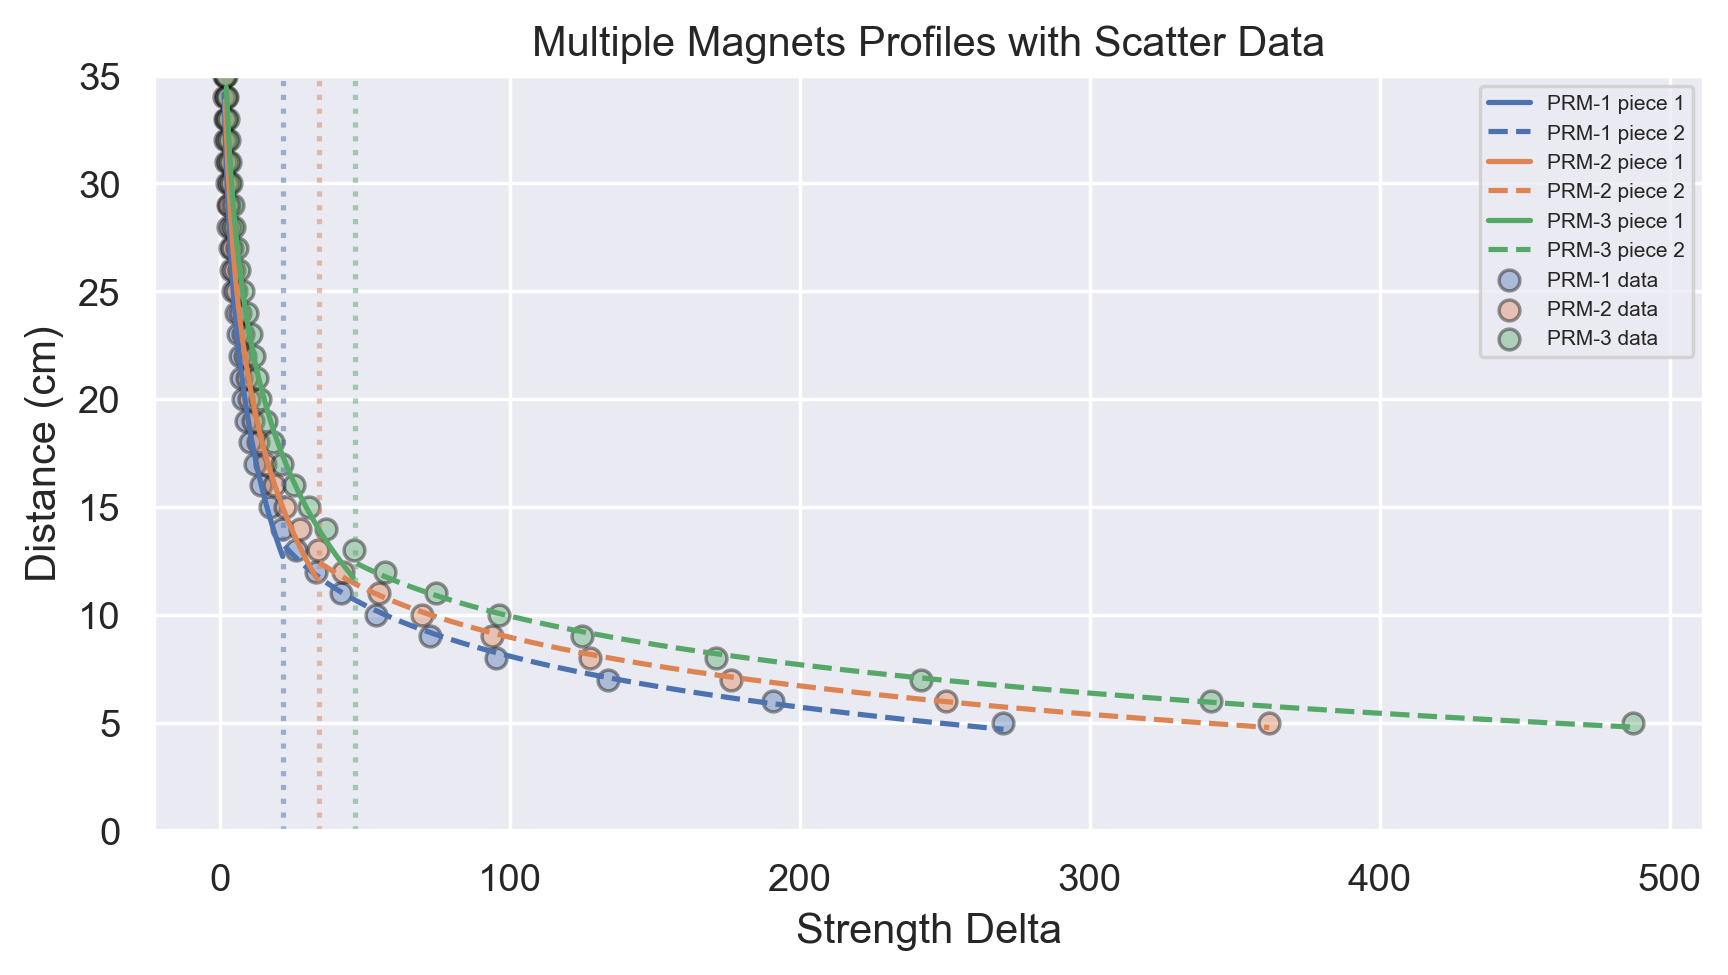

In [19]:
# Example usage
data = [
    ['PRM-1', prm_1_profile],
    ['PRM-2', prm_2_profile],
    ['PRM-3', prm_3_profile]
]
# Retrieve data and fits
base_dir = "./../data/mar-27-prlm-prm-prmm-strength-dist-corr-re-gather/"
prm_1_strengths, prm_1_distances = analyze_magnet_correlation(base_dir + "mar-27-prm-1-1.0cm-resolution-corr-regather.txt", magnet_type='PRM')
prm_2_strengths, prm_2_distances = analyze_magnet_correlation(base_dir + "mar-27-prm-2-1.0cm-resolution-corr-regather.txt", magnet_type='PRM')
prm_3_strengths, prm_3_distances = analyze_magnet_correlation(base_dir + "mar-27-prm-3-1.0cm-resolution-corr-regather.txt", magnet_type='PRM')

scatter_data = [(prm_1_strengths, prm_1_distances), (prm_2_strengths, prm_2_distances), (prm_3_strengths, prm_3_distances)]

plot_piecewise_log_functions(data, scatter_data)

In [20]:
def plot(data_input, gradients, stability_change_stamps, placement_stamps, removal_stamps):
    
    from matplotlib.ticker import ScalarFormatter

    formatter = ScalarFormatter(useOffset=False)
    
    anchor_name_dict = {0: "anchor_0", 1: "anchor_1", 2: "anchor_2", 3: "anchor_3", 4: "anchor_4"}

    
    # Set up subplots
    fig, axs = plt.subplots(10, 1, figsize=(10, 30), dpi=300)
    
    for indx in range(5):
        
         # Plot original data with placement and removal stamps
        axs[2 * indx].plot(data_input[anchor_name_dict[indx]], label=f'Original Data {anchor_name_dict[indx]}')

        # Initialize the legend handled dictionaries
        legend_handles = {'Placement': False, 'Removal': False}

        for stamp in placement_stamps:
            axs[2 * indx].axvline(x=stamp, color='g', linestyle='--')
            if not legend_handles['Placement']:
                axs[2 * indx].axvline(x=stamp, color='g', linestyle='--', label='Placement')
                legend_handles['Placement'] = True

        for stamp in removal_stamps:
            axs[2 * indx].axvline(x=stamp, color='r', linestyle='--')
            if not legend_handles['Removal']:
                axs[2 * indx].axvline(x=stamp, color='r', linestyle='--', label='Removal')
                legend_handles['Removal'] = True

        axs[2 * indx].set_title(f'Original Data with Event Markers {anchor_name_dict[indx]}')
        axs[2 * indx].set_xlabel('Samples')
        axs[2 * indx].set_ylabel('Field Strength (mV)')
        axs[2 * indx].xaxis.set_major_formatter(formatter)
        axs[2 * indx].yaxis.set_major_formatter(formatter)
        axs[2 * indx].legend(loc="upper right", prop={'size': 6})

        # Plot channel gradient and mark peaks based on correlation
        axs[2 * indx + 1].plot(gradients[indx, :], label=f'Gradient Tracking {anchor_name_dict[indx]}', color="orange")

        legend_handles = {'Placement': False, 'Removal': False}

        for stamp in placement_stamps:
            axs[2 * indx + 1].axvline(x=stamp, color='g', linestyle='--')
            if not legend_handles['Placement']:
                axs[2 * indx + 1].axvline(x=stamp, color='g', linestyle='--', label='Placement')
                legend_handles['Placement'] = True

        for stamp in removal_stamps:
            axs[2 * indx + 1].axvline(x=stamp, color='r', linestyle='--')
            if not legend_handles['Removal']:
                axs[2 * indx + 1].axvline(x=stamp, color='r', linestyle='--', label='Removal')
                legend_handles['Removal'] = True

        axs[2 * indx + 1].set_title(f'Channel Gradient {anchor_name_dict[indx]}')
        axs[2 * indx + 1].set_xlabel('Samples')
        axs[2 * indx + 1].set_ylabel('Gradient (mV/sample)')
        axs[2 * indx + 1].xaxis.set_major_formatter(formatter)
        axs[2 * indx + 1].yaxis.set_major_formatter(formatter)
        axs[2 * indx + 1].legend(loc="upper right", prop={'size': 6})
        
        
        
        
    plt.tight_layout()
    plt.show()
    
    return

    
    

In [29]:

def euclidean_dist(point1, point2):
    difference = np.array(point1) - np.array(point2)
    distance = np.sqrt(np.sum(difference ** 2))
    return distance

### Comprehensive Detection and Localization Function

This function is a sophisticated approach for real-time monitoring and localization based on sensor data. It's designed to identify the placement or removal of objects using magnetic sensor arrays and provides a robust framework for data analysis.

#### Overview:
The function processes sensory readings from multiple anchors (sensors) to detect significant changes, which could indicate the placement or removal of an object. It uses gradient-based methods to determine stability and employs trilateration for localization.

#### Key Features:
- **Stability Check**: Evaluates whether the sensory data from each anchor is stable, using a pre-defined threshold to ensure data reliability before processing.
- **Gradient Calculation**: Computes the derivative of sensor data to analyze the rate of change, aiding in identifying dynamic events.
- **Event Detection**: Identifies placement or removal events by comparing current sensor readings against historical stable values.
- **Localization**: Applies trilateration based on the positions of the anchors and the distances calculated from sensor readings, providing the estimated location of the event.
- **Performance Metrics**: Tracks processing time for localization, helping in the assessment of computational efficiency.

#### Process Flow:
1. **Initialize and Train**: Uses initial data points to set baseline stability thresholds.
2. **Iterative Analysis**:
   - For each data window, check stability across all sensors.
   - If stability criteria are met, check for significant changes that might indicate placement or removal.
   - Perform localization if an event is detected.
3. **Output Results**: Stores and returns all relevant event data, including timestamps, actions, positions, predicted and observed distances, and computational performance metrics.

#### Use Case Implementation:
This function is ideal for applications in logistics, warehousing, and security, where real-time monitoring and accurate localization of items are crucial. It ensures robust data processing by handling noise and temporal variability in sensor outputs.

#### Example Usage:
The function can be integrated into a system where sensors continuously monitor an environment. By feeding sensor data directly into this function, users can receive immediate feedback on events and their locations, which is vital for maintaining operational oversight in dynamic environments.


In [25]:
def stability_check(derivative_array, thresholds, len_chunks=5):
    
    summed_deri = np.array([])
    # aggregate the gradient sub-arrays for comparison
    for i in range(5):
        summed_deri = np.append(summed_deri, np.sum(np.abs(derivative_array[i*20: i*20 + 20])))
    # print(summed_deri)

    # compared all summed values to thresholds
    if (summed_deri[0] <= thresholds[0] and 
        summed_deri[1] <= thresholds[1] and 
        summed_deri[2] <= thresholds[2] and 
        summed_deri[3] <= thresholds[3] and 
        summed_deri[4] <= thresholds[4]):
        
        # successfully transitioned into stablized mode
        return True
    else:
        return False




def detect(data_input, training_amount, window_size=100, threshold_array=np.array([.65, .65, .65, .65, .65,]), stability_prom_threshold=2, anchor_prominence_ranking=True, identify_prom_threshold=3, ):

    """
    data_input: a five column pandas df with each column corresponds to a sensory reading. from anchor_0 to anchor_4 correspondingly.
    """


    anchor_0_derivative = np.nan_to_num(np.gradient(data_input["anchor_0"]))
    anchor_1_derivative = np.nan_to_num(np.gradient(data_input["anchor_1"]))
    anchor_2_derivative = np.nan_to_num(np.gradient(data_input["anchor_2"]))
    anchor_3_derivative = np.nan_to_num(np.gradient(data_input["anchor_3"]))
    anchor_4_derivative = np.nan_to_num(np.gradient(data_input["anchor_4"]))

    all_gradient_info = np.vstack((anchor_0_derivative, 
                                   anchor_1_derivative, 
                                   anchor_2_derivative, 
                                   anchor_3_derivative, 
                                   anchor_4_derivative))

#     print(all_gradient_info.shape)

    # Constants for the number of samples to check and the number of chunks
    num_samples = len(data_input["anchor_0"])
    len_chunks = window_size // len(threshold_array)  # Assuming threshold_array length divides window_size

    # Initialize arrays to hold the timestamps of various events    
    unstable_to_stable_stamp = []
    stable_to_unstable_stamp = []
    placement_stamps = []
    removal_stamps = []


    # some_threshold = 0.7
    stability_mode = False
    place_remove_add_flag = False
    anchor_prominence_pass_flag = False

    # Initialize a variable to track the last stable value for comparison
    # 5 different values for 5 different anchors correspondingly
    last_stable_values = [[], [], [], [], []]

    anchor_name_dict = {0: "anchor_0", 1: "anchor_1", 2: "anchor_2", 3: "anchor_3", 4: "anchor_4"}
    width = 50.8
    length = 76.2
    anchor_positions = np.array([(2.6, 2.6), (2.6, width-2.6), (length/2, width/2), (length-2.6, 2.6), (length-2.6, width-2.6)])

    # Define column names for the DataFrame
    column_names = ['timestamp', 'action', 
#                     'PRLM-1/pos-x', 'PRLM-1/pos-y', 'PRLM-1/predicted-distance', 'PRLM-1/observed-distance', 'PRLM-1/err',
                    
                    'PRM-1/pos-x', 'PRM-1/pos-y', 'PRM-1/predicted-distance', 'PRM-1/observed-distance', 'PRM-1/err',
                    'PRM-2/pos-x', 'PRM-2/pos-y', 'PRM-2/predicted-distance', 'PRM-2/observed-distance', 'PRM-2/err', 
                    'PRM-3/pos-x', 'PRM-3/pos-y', 'PRM-3/predicted-distance', 'PRM-3/observed-distance', 'PRM-3/err', 
#                     'PRM-4/pos-x', 'PRM-4/pos-y', 'PRM-4/predicted-distance', 'PRM-4/observed-distance', 'PRM-4/err', 
#                     'PRM-5/pos-x', 'PRM-5/pos-y', 'PRM-5/predicted-distance', 'PRM-5/observed-distance', 'PRM-5/err', 

                    
                    
#                     'PRMM-1/pos-x', 'PRMM-1/pos-y', 'PRMM-1/predicted-distance', 'PRMM-1/observed-distance', 'PRMM-1/err']
                    'time-elapsed-for-localisation/recognition'
                   ]

    # Re-initialize the DataFrame with these column names
    predict_summary_df = pd.DataFrame(columns=column_names)


    # define a function-wise helper function for dealing with placement and removal judgement
    def action_check(data_input, last_stable_values, anchor_indx, cur_time_stamp, window_size=100, threshold=0.2):

        current_stable_value_to_ret = np.mean(data_input)
        decision_to_ret = "none"
        reading_diff_to_ret = current_stable_value_to_ret - last_stable_values[anchor_indx][-1]
          
        # Check if there is a significant increase (placement)
        if reading_diff_to_ret > threshold:
            # placement_stamps.append(cur_time_stamp)
            last_stable_values[anchor_indx].append(current_stable_value_to_ret)
            decision_to_ret = "place"

        # Check if there is a significant decrease (removal)
        elif reading_diff_to_ret < -threshold:
            # removal_stamps.append(cur_time_stamp)
            last_stable_values[anchor_indx].append(current_stable_value_to_ret)
            decision_to_ret = "remove"

        # general update on the last stable values of all anchors, adaptive to sensor reading drifts
        else:
            last_stable_values[anchor_indx][-1] = current_stable_value_to_ret
        
        # return the corresponding place/remove signal to original judgment branch
        return decision_to_ret, reading_diff_to_ret

    def magnet_identify(place_or_remove, readings_array, cur_indx, ):
        
        # flip all values in removal cases
        if (place_or_remove == "remove"):
            readings_array = -readings_array
        
        # process the data: majority of the reading (difference) should be positive since it's a PLACE
        indice_sorted = np.argsort(readings_array)[::-1] # descending order
        reading_sorted = abs(readings_array[indice_sorted]) # avoid some random negative readings 
        # re-order the position array, prep for magnet identification usages
        position_sorted = anchor_positions[indice_sorted]
        # magnet identification here
        return localize(position_sorted[:identify_prom_threshold], 
                                      reading_sorted[:identify_prom_threshold], cur_indx, place_or_remove)

    
    # lift first "trianing_amount" data samples out to set the last_stable_values and stability check threshold array
    anchor_0_data_train = data_input[anchor_name_dict[0]][:training_amount]
    last_stable_values[0].append(np.mean(anchor_0_data_train))
    stability_threshold_anchor_0 = np.std(anchor_0_derivative[:training_amount])
    
    anchor_1_data_train = data_input[anchor_name_dict[1]][:training_amount]
    last_stable_values[1].append(np.mean(anchor_1_data_train))
    stability_threshold_anchor_1 = np.std(anchor_1_derivative[:training_amount])

    anchor_2_data_train = data_input[anchor_name_dict[2]][:training_amount]
    last_stable_values[2].append(np.mean(anchor_2_data_train))
    stability_threshold_anchor_2 = np.std(anchor_2_derivative[:training_amount])

    anchor_3_data_train = data_input[anchor_name_dict[3]][:training_amount]
    last_stable_values[3].append(np.mean(anchor_3_data_train))
    stability_threshold_anchor_3 = np.std(anchor_3_derivative[:training_amount])

    anchor_4_data_train = data_input[anchor_name_dict[4]][:training_amount]
    last_stable_values[4].append(np.mean(anchor_4_data_train))
    stability_threshold_anchor_4 = np.std(anchor_4_derivative[:training_amount])
    
#     print(f"training data standard deviations are as follows: {stability_threshold_anchor_0}, {stability_threshold_anchor_1}, {stability_threshold_anchor_2}, {stability_threshold_anchor_3}, {stability_threshold_anchor_4}")

    import time
    

    # Loop through gradient values in windows of `window_size`
    for indx in range(training_amount, num_samples, len_chunks):

        # Call stability check helper to determine all anchors [0:5] stability
        anchor_0_stability = stability_check(all_gradient_info[0, :].reshape(-1,)[indx:indx+window_size], thresholds=threshold_array)
        anchor_1_stability = stability_check(all_gradient_info[1, :].reshape(-1,)[indx:indx+window_size], thresholds=threshold_array)        
        anchor_2_stability = stability_check(all_gradient_info[2, :].reshape(-1,)[indx:indx+window_size], thresholds=threshold_array)
        anchor_3_stability = stability_check(all_gradient_info[3, :].reshape(-1,)[indx:indx+window_size], thresholds=threshold_array)
        anchor_4_stability = stability_check(all_gradient_info[4, :].reshape(-1,)[indx:indx+window_size], thresholds=threshold_array)
        anchors_stability  = [anchor_0_stability, anchor_1_stability, anchor_2_stability, anchor_3_stability, anchor_4_stability]

        anchor_0_data_windowed = data_input[anchor_name_dict[0]][indx:indx+window_size]
        anchor_1_data_windowed = data_input[anchor_name_dict[1]][indx:indx+window_size]
        anchor_2_data_windowed = data_input[anchor_name_dict[2]][indx:indx+window_size]
        anchor_3_data_windowed = data_input[anchor_name_dict[3]][indx:indx+window_size]
        anchor_4_data_windowed = data_input[anchor_name_dict[4]][indx:indx+window_size]

#         print(f"Current data segment is from {indx} to {indx + window_size}")
#         print(f"the stability status of anchors are as follows: {anchors_stability}")
        
        # Check whether pass through STABILITY PROMINENCE test
        if (sum(anchors_stability) >= stability_prom_threshold):
#             print(f"this round we passed the anchor stability test, hooray!!!")
                
            # Obtain the current stable values if pass through initial stablility test
            cur_anchor_0_val = np.mean(anchor_0_data_windowed)
            cur_anchor_1_val = np.mean(anchor_1_data_windowed)
            cur_anchor_2_val = np.mean(anchor_2_data_windowed)
            cur_anchor_3_val = np.mean(anchor_3_data_windowed)
            cur_anchor_4_val = np.mean(anchor_4_data_windowed)
            cur_anchors_vals = np.array([cur_anchor_0_val, cur_anchor_1_val, cur_anchor_2_val, cur_anchor_3_val, cur_anchor_4_val])
            prev_anchors_vals = np.array([last_stable_values[0][-1], last_stable_values[1][-1], last_stable_values[2][-1], last_stable_values[3][-1], last_stable_values[4][-1], ])
            cur_anchors_diffs = np.abs(cur_anchors_vals - prev_anchors_vals)

            # Check whether pass through ORDERED STABILITY PROMINENCE test
            if (anchor_prominence_ranking):
                indice_sorted = np.argsort(cur_anchors_diffs)[::-1]
#                 print(cur_anchors_diffs)
#                 print(f"the sorted indices are as follows: {indice_sorted}")
                prominent_anchors = indice_sorted[:stability_prom_threshold]

                for anchor_indx in range(stability_prom_threshold):
                    # replace the prominent anchor indx with that corresponding anchor's stability mode
                    prominent_anchors[anchor_indx] = anchors_stability[prominent_anchors[anchor_indx]]
                    
#                 print(f"the prominent anchor stability status are as follows: {prominent_anchors}")
                # judge wether all results in prominent_anchors array are True
                if (np.sum(prominent_anchors) >= stability_prom_threshold):
                    # if ORDERed STABILITY PROMINENCE test did not pass, return to the outer loop
                    # print(f"we didn't pass the anchor stability + prominence test, sad...")
                    anchor_prominence_pass_flag = True
            
#                     print(f"np.sum(prominent_anchors) outputs {np.sum(prominent_anchors)}, anchor_prominence_pass_flag is <{anchor_prominence_pass_flag}>, prominent_anchor stability status are {prominent_anchors}")
            # Record the time stamp for the moment {UNSTABLE -> STABLE}
            if not stability_mode:
                if ((anchor_prominence_ranking and anchor_prominence_pass_flag) or (not anchor_prominence_ranking)):
#                     print(f"system moves from UNSTABLE into STABLE")
                    stability_mode = True
                    unstable_to_stable_stamp.append(indx)
                    place_remove_add_flag = True
            
            elif stability_mode and (anchor_prominence_ranking and not anchor_prominence_pass_flag):
#                 print(f"stability test with prominence didn't pass")
                # Record the time stamp for the moment {STABLE -> UNSTABLE}
                if stability_mode:
#                     print(f"system moves from STABLE into UNSTABLE")
                    stability_mode = False
                    stable_to_unstable_stamp.append(indx)
                    

            anchor_prominence_pass_flag = False

        # STABILITY PROMINENCE test did not pass
        else:
#             print(f"stability test with prominence didn't pass")
            # Record the time stamp for the moment {STABLE -> UNSTABLE}
            if stability_mode:
#                 print(f"system moves from STABLE into UNSTABLE")
                stability_mode = False
                stable_to_unstable_stamp.append(indx)


        
        # ONLY check place/remove if flagged
        if (place_remove_add_flag):

            # lower the flag to aovid miss-interpretation in the future
            place_remove_add_flag = False
            
            # compute all anchors placement removal actions based stable value variations
            anchor_0_action, anchor_0_read = action_check(anchor_0_data_windowed, last_stable_values, 0, indx)
            anchor_1_action, anchor_1_read = action_check(anchor_1_data_windowed, last_stable_values, 1, indx)
            anchor_2_action, anchor_2_read = action_check(anchor_2_data_windowed, last_stable_values, 2, indx)
            anchor_3_action, anchor_3_read = action_check(anchor_3_data_windowed, last_stable_values, 3, indx)
            anchor_4_action, anchor_4_read = action_check(anchor_4_data_windowed, last_stable_values, 4, indx)
            
            # make an array for counting occurrence of specific "remove"/"place" events
            actions_array = np.array([anchor_0_action, anchor_1_action, anchor_2_action, anchor_3_action, anchor_4_action])
            readings_array = np.array([anchor_0_read, anchor_1_read, anchor_2_read, anchor_3_read, anchor_4_read])
#             print(f"the current ACTION detection result is as follows: [anchor_0:{actions_array[0]}, anchor_1:{actions_array[1]}, anchor_2:{actions_array[2]}, anchor_3:{actions_array[3]}, anchor_4:{actions_array[4]}]")
#             print(f"the current READINGs are as follows: [anchor_0:{readings_array[0]}, anchor_1:{readings_array[1]}, anchor_2:{readings_array[2]}, anchor_3:{readings_array[3]}, anchor_4:{readings_array[4]}]")

            place_occur = np.count_nonzero(actions_array == "place")
            remove_occur = np.count_nonzero(actions_array == "remove")
            
            # first we need to make sure more than "stability_prom_threshold" number of anchors UNANIMOUSly report some events
            if (place_occur >= stability_prom_threshold or remove_occur >= stability_prom_threshold):
                
                # Record the start time (tick)
                start_time = time.perf_counter()
                
                # here we check for whether it's a place or a remove 
                if (place_occur > remove_occur):
                    placement_stamps.append(indx)
                    prediction_result_dict = magnet_identify("place", readings_array, indx)
                    
                    # Record the end time (tick)
                    end_time = time.perf_counter()
                    # Calculate the time elapsed
                    elapsed_time = end_time - start_time
                    prediction_result_dict['time-elapsed-for-localisation/recognition'] = elapsed_time
                    
                    predict_summary_df = predict_summary_df.append(prediction_result_dict, ignore_index=True)

                    
                elif (remove_occur > place_occur):
                    removal_stamps.append(indx)
                    prediction_result_dict = magnet_identify("remove", readings_array, indx)
                    
                    # Record the end time (tick)
                    end_time = time.perf_counter()
                    # Calculate the time elapsed
                    elapsed_time = end_time - start_time
                    prediction_result_dict['time-elapsed-for-localisation/recognition'] = elapsed_time
                    
                    
                    predict_summary_df = predict_summary_df.append(prediction_result_dict, ignore_index=True)

    
#         print("======================================================================================================")

#     for indx in range(len(last_stable_values)):
#         print(f"anchor_{indx} historical stablized values: {last_stable_values[indx]}")
    
#     print(predict_summary_df)

    return  all_gradient_info, unstable_to_stable_stamp, stable_to_unstable_stamp, placement_stamps, removal_stamps, predict_summary_df

In [794]:
# def calculate_thresholds(baseline_data, chunk_size, method='intuition', data_type="raw"):
#     if data_type=="1st_derivative":
#         baseline_data = np.nan_to_num(np.gradient(baseline_data))
#     elif data_type=="2nd_derivative":
#         baseine_data = np.nan_to_num(np.gradient(np.gradient(baseline_data)))
        
#     num_chunks = len(baseline_data) // chunk_size
#     measure_func = lambda chunk: np.percentile(chunk, 99.5) - np.mean(chunk)
#     chunk_measures = [measure_func(baseline_data[i*chunk_size:(i+1)*chunk_size]) for i in range(num_chunks)]
#     avg_threshold = np.mean(chunk_measures)
#     return avg_threshold

# def stability_check(data, thresholds, method='intuition', num_chunks=5, chunk_size=10):
#     # Check the selected method and apply the appropriate stability analysis
# #     print(f"the method used in stability check func: {method}")


#     if method == 'std':
#         # Method 2: Standard Deviation Check
#         std_values = []
#         for i in range(num_chunks):
#             chunk = data[i * chunk_size:i * chunk_size + chunk_size]
#             std_dev = np.std(chunk)
#             std_values.append(std_dev)
# #         print(std_values)
# #         print(np.all(np.array(std_values) <= thresholds))
#         return np.all(np.array(std_values) <= thresholds)

#     elif method == 'intuition':
#         # Method 3: Adjusted Percentile-based Check (Zero-mean average deviation check)
#         deviations = []
#         for i in range(num_chunks):
#             chunk = data[i * chunk_size:(i + 1) * chunk_size]
#             # Zero-mean the chunk
#             chunk_zero_meaned = chunk - np.mean(chunk)
#             # Calculate the average of the zero-meaned values (essentially the average deviation from the mean)
#             avg_deviation = np.mean(np.abs(chunk_zero_meaned))
#             deviations.append(avg_deviation)

#         # Compare each chunk's average deviation to the corresponding threshold
#         stability_result = np.all(np.array(deviations) <= thresholds)
# #         print(stability_result)
#         return stability_result

#     else:
#         raise ValueError("Unknown method specified. Use 'gradient', 'std', or 'percentile'.")


# def detect(data_input, training_amount, window_size=50, threshold_array_len=5, method="intuition", data_type="1st_derivative", threshold_multipliers=None, stability_prom_threshold=2, anchor_prominence_ranking=True, identify_prom_threshold=3, ):

#     """
#     data_input: a five column pandas df with each column corresponds to a sensory reading. from anchor_0 to anchor_4 correspondingly.
#     """
# #     print(f"data is of length {len(data_input['anchor_0'])}")
#     all_raw_data = np.vstack((data_input["anchor_0"], 
#                               data_input["anchor_1"], 
#                               data_input["anchor_2"], 
#                               data_input["anchor_3"], 
#                               data_input["anchor_4"]))

#     anchor_0_1st_deri = np.nan_to_num(np.gradient(data_input["anchor_0"]))
#     anchor_1_1st_deri = np.nan_to_num(np.gradient(data_input["anchor_1"]))
#     anchor_2_1st_deri = np.nan_to_num(np.gradient(data_input["anchor_2"]))
#     anchor_3_1st_deri = np.nan_to_num(np.gradient(data_input["anchor_3"]))
#     anchor_4_1st_deri = np.nan_to_num(np.gradient(data_input["anchor_4"]))

#     all_1st_deri_info = np.vstack((anchor_0_1st_deri, 
#                                    anchor_1_1st_deri, 
#                                    anchor_2_1st_deri, 
#                                    anchor_3_1st_deri, 
#                                    anchor_4_1st_deri))
    
#     anchor_0_2nd_deri = np.nan_to_num(np.gradient(anchor_0_1st_deri))
#     anchor_1_2nd_deri = np.nan_to_num(np.gradient(anchor_1_1st_deri))
#     anchor_2_2nd_deri = np.nan_to_num(np.gradient(anchor_2_1st_deri))
#     anchor_3_2nd_deri = np.nan_to_num(np.gradient(anchor_3_1st_deri))
#     anchor_4_2nd_deri = np.nan_to_num(np.gradient(anchor_4_1st_deri))

#     all_2nd_deri_info = np.vstack((anchor_0_2nd_deri, 
#                                    anchor_1_2nd_deri, 
#                                    anchor_2_2nd_deri, 
#                                    anchor_3_2nd_deri, 
#                                    anchor_4_2nd_deri))

# #     print(all_gradient_info.shape)

#     # Constants for the number of samples to check and the number of chunks
#     num_samples = len(data_input["anchor_0"])
#     chunk_size = window_size // threshold_array_len

#     # Initialize arrays to hold the timestamps of various events    
#     unstable_to_stable_stamp = []
#     stable_to_unstable_stamp = []
#     placement_stamps = []
#     removal_stamps = []


#     # some_threshold = 0.7
#     stability_mode = False
#     place_remove_add_flag = False
#     anchor_prominence_pass_flag = False

#     # Initialize a variable to track the last stable value for comparison
#     # 5 different values for 5 different anchors correspondingly
#     last_stable_values = [[], [], [], [], []]

#     anchor_name_dict = {0: "anchor_0", 1: "anchor_1", 2: "anchor_2", 3: "anchor_3", 4: "anchor_4"}
#     width = 50.8
#     length = 76.2
#     anchor_positions = np.array([(2.6, 2.6), (2.6, width-2.6), (length/2, width/2), (length-2.6, 2.6), (length-2.6, width-2.6)])

#     # Define column names for the DataFrame
#     column_names = ['timestamp', 'action', 
                    
#                     'PRLM-1/pos-x', 'PRLM-1/pos-y', 'PRLM-1/predicted-distance', 'PRLM-1/observed-distance', 'PRLM-1/err',
                    
#                     'PRM-1/pos-x', 'PRM-1/pos-y', 'PRM-1/predicted-distance', 'PRM-1/observed-distance', 'PRM-1/err',
#                     'PRM-2/pos-x', 'PRM-2/pos-y', 'PRM-2/predicted-distance', 'PRM-2/observed-distance', 'PRM-2/err', 
#                     'PRM-3/pos-x', 'PRM-3/pos-y', 'PRM-3/predicted-distance', 'PRM-3/observed-distance', 'PRM-3/err', 
#                     'PRM-4/pos-x', 'PRM-4/pos-y', 'PRM-4/predicted-distance', 'PRM-4/observed-distance', 'PRM-4/err', 
#                     'PRM-5/pos-x', 'PRM-5/pos-y', 'PRM-5/predicted-distance', 'PRM-5/observed-distance', 'PRM-5/err',               
                    
#                     'PRMM-1/pos-x', 'PRMM-1/pos-y', 'PRMM-1/predicted-distance', 'PRMM-1/observed-distance', 'PRMM-1/err']

#     # Re-initialize the DataFrame with these column names
#     predict_summary_df = pd.DataFrame(columns=column_names)


#     # define a function-wise helper function for dealing with placement and removal judgement
#     def action_check(data_input, last_stable_values, anchor_indx, cur_time_stamp, window_size=100, threshold=0.2):

#         current_stable_value_to_ret = np.mean(data_input)
#         decision_to_ret = "none"
#         reading_diff_to_ret = current_stable_value_to_ret - last_stable_values[anchor_indx][-1]
        
#         # Check if there is a significant increase (placement)
#         if reading_diff_to_ret > threshold:
#             # placement_stamps.append(cur_time_stamp)
#             last_stable_values[anchor_indx].append(current_stable_value_to_ret)
#             decision_to_ret = "place"

#         # Check if there is a significant decrease (removal)
#         elif reading_diff_to_ret < -threshold:
#             # removal_stamps.append(cur_time_stamp)
#             last_stable_values[anchor_indx].append(current_stable_value_to_ret)
#             decision_to_ret = "remove"

#         # general update on the last stable values of all anchors, adaptive to sensor reading drifts
#         else:
#             last_stable_values[anchor_indx][-1] = current_stable_value_to_ret
        
#         # return the corresponding place/remove signal to original judgment branch
#         return decision_to_ret, reading_diff_to_ret

#     def magnet_identify(place_or_remove, readings_array, cur_indx, ):
        
#         # flip all values in removal cases
#         if (place_or_remove == "remove"):
#             readings_array = -readings_array
        
#         # process the data: majority of the reading (difference) should be positive since it's a PLACE
#         indice_sorted = np.argsort(readings_array)[::-1] # descending order
#         reading_sorted = abs(readings_array[indice_sorted]) # avoid some random negative readings 
#         # re-order the position array, prep for magnet identification usages
#         position_sorted = anchor_positions[indice_sorted]
#         # magnet identification here
#         return localize(position_sorted[:identify_prom_threshold], 
#                                       reading_sorted[:identify_prom_threshold], cur_indx, place_or_remove)

#     if threshold_multipliers is None:
#         threshold_multipliers = np.ones(threshold_array_len)  # Default to all ones if none provided
#     else:
#         threshold_multipliers = np.array(threshold_multipliers)
    
#     # lift first "trianing_amount" data samples out to set the last_stable_values and stability check threshold array
#     anchor_0_data_train = data_input[anchor_name_dict[0]][:training_amount]
#     last_stable_values[0].append(np.mean(anchor_0_data_train))
# #     stability_threshold_anchor_0 = np.std(anchor_0_derivative[:training_amount])
#     stability_threshold_anchor_0 = threshold_multipliers * calculate_thresholds(baseline_data=anchor_0_data_train, chunk_size=chunk_size, method=method, data_type=data_type)
    
#     anchor_1_data_train = data_input[anchor_name_dict[1]][:training_amount]
#     last_stable_values[1].append(np.mean(anchor_1_data_train))
# #     stability_threshold_anchor_1 = np.std(anchor_1_derivative[:training_amount])
#     stability_threshold_anchor_1 = threshold_multipliers * calculate_thresholds(baseline_data=anchor_1_data_train, chunk_size=chunk_size, method=method, data_type=data_type)


#     anchor_2_data_train = data_input[anchor_name_dict[2]][:training_amount]
#     last_stable_values[2].append(np.mean(anchor_2_data_train))
# #     stability_threshold_anchor_2 = np.std(anchor_2_derivative[:training_amount])
#     stability_threshold_anchor_2 = threshold_multipliers * calculate_thresholds(baseline_data=anchor_2_data_train, chunk_size=chunk_size, method=method, data_type=data_type)


#     anchor_3_data_train = data_input[anchor_name_dict[3]][:training_amount]
#     last_stable_values[3].append(np.mean(anchor_3_data_train))
# #     stability_threshold_anchor_3 = np.std(anchor_3_derivative[:training_amount])
#     stability_threshold_anchor_3 = threshold_multipliers * calculate_thresholds(baseline_data=anchor_3_data_train, chunk_size=chunk_size, method=method, data_type=data_type)


#     anchor_4_data_train = data_input[anchor_name_dict[4]][:training_amount]
#     last_stable_values[4].append(np.mean(anchor_4_data_train))
# #     stability_threshold_anchor_4 = np.std(anchor_4_derivative[:training_amount])
#     stability_threshold_anchor_4 = threshold_multipliers * calculate_thresholds(baseline_data=anchor_4_data_train, chunk_size=chunk_size, method=method, data_type=data_type)

# #     print(f"thresholds are correspondingly as follows: {stability_threshold_anchor_0, stability_threshold_anchor_1, stability_threshold_anchor_2, stability_threshold_anchor_3, stability_threshold_anchor_4}")
# #     print(f"training data standard deviations are as follows: {stability_threshold_anchor_0}, {stability_threshold_anchor_1}, {stability_threshold_anchor_2}, {stability_threshold_anchor_3}, {stability_threshold_anchor_4}")

#     processed_data = all_raw_data
    
#     if data_type == "1st_derivative":
#         processed_data = all_1st_deri_info
#     elif data_type == "2nd_derivative":
#         processed_data = all_2nd_deri_info
    

#     # Loop through gradient values in windows of `window_size`
#     for indx in range(0, num_samples - window_size, chunk_size):
        
# #         print(f"now we are processing data from {indx} to {indx + window_size}")

#         # Call stability check helper to determine all anchors [0:5] stability
#         anchor_0_stability = stability_check(data=processed_data[0, :].reshape(-1,)[indx:indx+window_size], thresholds=stability_threshold_anchor_0, method=method, num_chunks=threshold_array_len, chunk_size=chunk_size)
#         anchor_1_stability = stability_check(data=processed_data[1, :].reshape(-1,)[indx:indx+window_size], thresholds=stability_threshold_anchor_1, method=method, num_chunks=threshold_array_len, chunk_size=chunk_size)
#         anchor_2_stability = stability_check(data=processed_data[2, :].reshape(-1,)[indx:indx+window_size], thresholds=stability_threshold_anchor_2, method=method, num_chunks=threshold_array_len, chunk_size=chunk_size)
#         anchor_3_stability = stability_check(data=processed_data[3, :].reshape(-1,)[indx:indx+window_size], thresholds=stability_threshold_anchor_3, method=method, num_chunks=threshold_array_len, chunk_size=chunk_size)
#         anchor_4_stability = stability_check(data=processed_data[4, :].reshape(-1,)[indx:indx+window_size], thresholds=stability_threshold_anchor_4, method=method, num_chunks=threshold_array_len, chunk_size=chunk_size)
#         anchors_stability  = [anchor_0_stability, anchor_1_stability, anchor_2_stability, anchor_3_stability, anchor_4_stability]

#         anchor_0_data_windowed = data_input[anchor_name_dict[0]][indx:indx+window_size]
#         anchor_1_data_windowed = data_input[anchor_name_dict[1]][indx:indx+window_size]
#         anchor_2_data_windowed = data_input[anchor_name_dict[2]][indx:indx+window_size]
#         anchor_3_data_windowed = data_input[anchor_name_dict[3]][indx:indx+window_size]
#         anchor_4_data_windowed = data_input[anchor_name_dict[4]][indx:indx+window_size]

# #         print(f"Current data segment is from {indx} to {indx + window_size}")
# #         print(f"the stability status of anchors are as follows: {anchors_stability}")
        
#         # Check whether pass through STABILITY PROMINENCE test
#         if (sum(anchors_stability) >= stability_prom_threshold):
# #             print(f"this round we passed the anchor stability test, hooray!!!")
                
#             # Obtain the current stable values if pass through initial stablility test
#             cur_anchor_0_val = np.mean(anchor_0_data_windowed)
#             cur_anchor_1_val = np.mean(anchor_1_data_windowed)
#             cur_anchor_2_val = np.mean(anchor_2_data_windowed)
#             cur_anchor_3_val = np.mean(anchor_3_data_windowed)
#             cur_anchor_4_val = np.mean(anchor_4_data_windowed)
#             cur_anchors_vals = np.array([cur_anchor_0_val, cur_anchor_1_val, cur_anchor_2_val, cur_anchor_3_val, cur_anchor_4_val])
#             prev_anchors_vals = np.array([last_stable_values[0][-1], last_stable_values[1][-1], last_stable_values[2][-1], last_stable_values[3][-1], last_stable_values[4][-1], ])
#             cur_anchors_diffs = np.abs(cur_anchors_vals - prev_anchors_vals)

#             # Check whether pass through ORDERED STABILITY PROMINENCE test
#             if (anchor_prominence_ranking):
#                 indice_sorted = np.argsort(cur_anchors_diffs)[::-1]
# #                 print(cur_anchors_diffs)
# #                 print(f"the sorted indices are as follows: {indice_sorted}")
#                 prominent_anchors = indice_sorted[:stability_prom_threshold]

#                 for anchor_indx in range(stability_prom_threshold):
#                     # replace the prominent anchor indx with that corresponding anchor's stability mode
#                     prominent_anchors[anchor_indx] = anchors_stability[prominent_anchors[anchor_indx]]
                    
# #                 print(f"the prominent anchor stability status are as follows: {prominent_anchors}")
#                 # judge wether all results in prominent_anchors array are True
#                 if (np.sum(prominent_anchors) >= stability_prom_threshold):
#                     # if ORDERed STABILITY PROMINENCE test did not pass, return to the outer loop
#                     # print(f"we didn't pass the anchor stability + prominence test, sad...")
#                     anchor_prominence_pass_flag = True
            
# #                     print(f"np.sum(prominent_anchors) outputs {np.sum(prominent_anchors)}, anchor_prominence_pass_flag is <{anchor_prominence_pass_flag}>, prominent_anchor stability status are {prominent_anchors}")
#             # Record the time stamp for the moment {UNSTABLE -> STABLE}
#             if not stability_mode:
#                 if ((anchor_prominence_ranking and anchor_prominence_pass_flag) or (not anchor_prominence_ranking)):
# #                     print(f"system moves from UNSTABLE into STABLE")
#                     stability_mode = True
#                     unstable_to_stable_stamp.append(indx)
#                     place_remove_add_flag = True
            
#             elif stability_mode and (anchor_prominence_ranking and not anchor_prominence_pass_flag):
# #                 print(f"stability test with prominence didn't pass")
#                 # Record the time stamp for the moment {STABLE -> UNSTABLE}
#                 if stability_mode:
# #                     print(f"system moves from STABLE into UNSTABLE")
#                     stability_mode = False
#                     stable_to_unstable_stamp.append(indx)
                    

#             anchor_prominence_pass_flag = False

#         # STABILITY PROMINENCE test did not pass
#         else:
# #             print(f"stability test with prominence didn't pass")
#             # Record the time stamp for the moment {STABLE -> UNSTABLE}
#             if stability_mode:
# #                 print(f"system moves from STABLE into UNSTABLE")
#                 stability_mode = False
#                 stable_to_unstable_stamp.append(indx)


        
#         # ONLY check place/remove if flagged
#         if (place_remove_add_flag):

#             # lower the flag to aovid miss-interpretation in the future
#             place_remove_add_flag = False
            
#             # compute all anchors placement removal actions based stable value variations
#             anchor_0_action, anchor_0_read = action_check(anchor_0_data_windowed, last_stable_values, 0, indx)
#             anchor_1_action, anchor_1_read = action_check(anchor_1_data_windowed, last_stable_values, 1, indx)
#             anchor_2_action, anchor_2_read = action_check(anchor_2_data_windowed, last_stable_values, 2, indx)
#             anchor_3_action, anchor_3_read = action_check(anchor_3_data_windowed, last_stable_values, 3, indx)
#             anchor_4_action, anchor_4_read = action_check(anchor_4_data_windowed, last_stable_values, 4, indx)
            
#             # make an array for counting occurrence of specific "remove"/"place" events
#             actions_array = np.array([anchor_0_action, anchor_1_action, anchor_2_action, anchor_3_action, anchor_4_action])
#             readings_array = np.array([anchor_0_read, anchor_1_read, anchor_2_read, anchor_3_read, anchor_4_read])
# #             print(f"the current ACTION detection result is as follows: [anchor_0:{actions_array[0]}, anchor_1:{actions_array[1]}, anchor_2:{actions_array[2]}, anchor_3:{actions_array[3]}, anchor_4:{actions_array[4]}]")
# #             print(f"the current READINGs are as follows: [anchor_0:{readings_array[0]}, anchor_1:{readings_array[1]}, anchor_2:{readings_array[2]}, anchor_3:{readings_array[3]}, anchor_4:{readings_array[4]}]")

#             place_occur = np.count_nonzero(actions_array == "place")
#             remove_occur = np.count_nonzero(actions_array == "remove")
            
#             # first we need to make sure more than "stability_prom_threshold" number of anchors UNANIMOUSly report some events
#             if (place_occur >= stability_prom_threshold or remove_occur >= stability_prom_threshold):
                
#                 # here we check for whether it's a place or a remove 
#                 if (place_occur > remove_occur):
#                     placement_stamps.append(indx)
#                     prediction_result_dict = magnet_identify("place", readings_array, indx)
#                     predict_summary_df = predict_summary_df.append(prediction_result_dict, ignore_index=True)

                    
#                 elif (remove_occur > place_occur):
#                     removal_stamps.append(indx)
#                     prediction_result_dict = magnet_identify("remove", readings_array, indx)
#                     predict_summary_df = predict_summary_df.append(prediction_result_dict, ignore_index=True)

                

                
#                 # here we run the magnet identification algorithm to label WHICH bottle has been placed at WHICH specific location 
#                 # TODO
    
# #         print("======================================================================================================")

# #     for indx in range(len(last_stable_values)):
# #         print(f"anchor_{indx} historical stablized values: {last_stable_values[indx]}")
    
# #     print(predict_summary_df)

#     return  processed_data, unstable_to_stable_stamp, stable_to_unstable_stamp, placement_stamps, removal_stamps, predict_summary_df


    


In [21]:
def detect_localize_plot(data_input, training_amount=180, stability_prom_threshold=2,anchor_prominence_ranking=True,identify_prom_threshold=3):
    # distinguish and mark all important stamps
    all_gradient_info, unstable_to_stable_stamp, stable_to_unstable_stamp, placement_stamps, removal_stamps, predict_summary_df = \
        detect(data_input, training_amount=training_amount, stability_prom_threshold=stability_prom_threshold, 
               anchor_prominence_ranking=anchor_prominence_ranking, identify_prom_threshold=identify_prom_threshold, window_size=50)
    
    
#     print(f"unstable_to_stable_stamp: {unstable_to_stable_stamp}")
#     print(f"stable_to_unstable_stamp: {stable_to_unstable_stamp}")
#     print(f"placement_stamps: {placement_stamps}")
#     print(f"removal_stamps: {removal_stamps}")
    
    # localize after each placement/removal stamp
    
    # plot all 5 channels and corresponding 1st derivative trace, with stability-change/place/remove/ labeled
#     plot(data_input, all_gradient_info, unstable_to_stable_stamp + stable_to_unstable_stamp, placement_stamps, removal_stamps)

    return predict_summary_df

In [22]:
import os

def load_filenames(directory):
    """Load all filenames in the specified directory into a list of strings, sorted alphabetically."""
    # Get the list of all files and directories in the specified directory
    filenames = os.listdir(directory)
    # Filter out directories, only keep file names
    filenames = [file for file in filenames if os.path.isfile(os.path.join(directory, file))]
    # Sort the file names alphabetically
    filenames = sorted(filenames)
    return filenames
# print(load_filenames("/Users/wangyaohui/Desktop/everything/cs@illinois/ms_research/SMART-STORAGE/algorithm-impl/MaintStorage/data/apr-8-prmm-localisation-data-each-position"))

In [23]:
def generate_locations():
    locations = []
    # Iterate x from 2.5 to 72.5 in steps of 5
    x_values = np.linspace(2.5, 72.5, 15)
    y_values = range(0, 51, 5)

    # Define exclusion sets based on your specifications
    excluded_edges = {(2.5, 0), (2.5, 5), (2.5, 45), (2.5, 50),
                      (7.5, 0), (7.5, 5), (7.5, 45), (7.5, 50), 
                      (72.5, 0), (72.5, 5), (72.5, 45), (72.5, 50),
                      (67.5, 0), (67.5, 5), (67.5, 45), (67.5, 50), }
    excluded_middle = {(32.5, 20), (32.5, 25), (32.5, 30),
                       (37.5, 20), (37.5, 25), (37.5, 30),
                       (42.5, 20), (42.5, 25), (42.5, 30)}

    # Generate coordinates considering exclusions
    for x in x_values:
        for y in y_values:
            if ((x, y) not in excluded_edges) and ((x, y) not in excluded_middle):
                locations.append((x, y))

    return locations

### **Detailed Workflow of a Detection and Localization System**

This section provides a comprehensive example of how a detection and localization system processes data in a practical application. The code is designed to evaluate sensor data to detect events (like placement or removal of objects) and localize them based on readings from multiple sensors. This demonstration focuses on how the system manages data, performs calculations, and integrates various functions to provide meaningful output.

#### Key Components of the Workflow:
- **Data Loading and Preprocessing**: Loads sensor data from files and preprocesses it for analysis.
- **Detection and Localization**: Utilizes a custom function (`detect_localize_plot`) to analyze sensor data and detect placement or removal actions.
- **Statistical Analysis**: Computes various statistics such as count of events, compliance with tolerance levels, and average positions.
- **Result Compilation**: Aggregates all results into a structured format (Pandas DataFrame) for further analysis or reporting.

#### Workflow Process:
1. **Initialize Environment**:
   - Load necessary libraries and define helper functions.
   - Define paths and load filenames from a base directory.

2. **Data Processing in a Loop**:
   - For each file:
     - Load data and pass it to the detection and localization function.
     - Extract relevant statistics for both 'place' and 'remove' actions.
     - Calculate Euclidean distances and check if actions are within a defined tolerance range.
     - Aggregate all statistics into a DataFrame.

3. **Output Results**:
   - Store the results in a CSV file for easy access and further analysis.

#### Highlights:
- **Flexibility**: The system can adapt to different sensor configurations and environmental conditions.
- **Accuracy**: Implements checks to ensure the accuracy of the localization relative to a ground truth.
- **Performance Metrics**: Calculates latency metrics to evaluate the efficiency of the detection and localization process.

#### Example Code Usage:
This example demonstrates a real-world application scenario where sensor data from a storage facility is analyzed to track item placements and removals. The detailed statistics help in understanding the system's performance and accuracy in a dynamic environment.


In [32]:

# Convert all warnings to exceptions
# warnings.filterwarnings('error')


import pandas as pd

# Function to compute the Euclidean distance
def euclidean_dist(coord1, coord2):
    return ((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)**0.5

# Function to check if the position is within ±10 cm of the ground truth
def within_tolerance(predicted, ground_truth, tolerance=10):
    return abs(predicted[0] - ground_truth[0]) <= tolerance and abs(predicted[1] - ground_truth[1]) <= tolerance

# Assuming load_filenames and generate_locations are defined elsewhere
base_dir = "/Users/wangyaohui/Desktop/everything/cs@illinois/ms_research/SMART-STORAGE/algorithm-impl/MaintStorage/data/apr-4-prlm-localisation-data-each-position"
all_filenames = load_filenames(base_dir)
all_locations = generate_locations()

# Assuming all other functions and imports are defined as previously mentioned

# Initialize DataFrame with specified rows and columns
x_range = np.arange(2.5, 77.5, 5)  # Adjusted to include 72.5
y_range = np.arange(0, 55, 5)  # Adjusted to include 50

# Create a MultiIndex from the product of these ranges
index = pd.MultiIndex.from_product([x_range, y_range], names=['X', 'Y'])

# Define the DataFrame with specific columns for each statistic
columns = [
    'Place_Count', 'Place_Within_Tolerance', 'Place_Recognized_as_PRLM-1',
    'Place_Pos_X', 'Place_Pos_Y', 'Place_Euclidean_Distance', 'Place_Latency_Avg',
    'Remove_Count', 'Remove_Within_Tolerance', 'Remove_Recognized_as_PRLM-1',
    'Remove_Pos_X', 'Remove_Pos_Y', 'Remove_Euclidean_Distance', 'Remove_Latency_Avg'
]
stats_df = pd.DataFrame(index=index, columns=columns)


for indx, filename in enumerate(all_filenames):
    data = pd.read_csv(f"{base_dir}/{filename}", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])
    predict_summary_df = detect_localize_plot(data, stability_prom_threshold=1, anchor_prominence_ranking=True, identify_prom_threshold=3)
#     print(predict_summary_df[["timestamp", "action", "PRMM-1/err",  'time-elapsed-for-localisation/recognition']])
#     print(predict_summary_df[(predict_summary_df['PRM-1/err'] < predict_summary_df['PRM-2/err']) &
#                              (predict_summary_df['PRM-1/err'] < predict_summary_df['PRM-3/err'])][["timestamp", "action", "PRM-1/err", "PRM-2/err", "PRM-3/err"]])

    GROUND_TRUTH = all_locations[indx]
    adjusted_gt = (GROUND_TRUTH[0] + 0.6, GROUND_TRUTH[1] + 0.4)

    # Calculate statistics for 'place' actions
    place_predictions = predict_summary_df[predict_summary_df['action'] == 'place']
    place_stats = {
        'Place_Count': len(place_predictions),
        'Place_Within_Tolerance': place_predictions.apply(lambda row: within_tolerance((row['PRLM-1/pos-x'], row['PRLM-1/pos-y']), adjusted_gt), axis=1).sum(),
        'Place_Recognized_as_PRLM-1': ((place_predictions['PRLM-1/err'] < place_predictions['PRM-1/err']) & (place_predictions['PRLM-1/err'] < place_predictions['PRMM-1/err'])).sum(),
        'Place_Pos_X': place_predictions['PRLM-1/pos-x'].mean(),
        'Place_Pos_Y': place_predictions['PRLM-1/pos-y'].mean(),
        'Place_Euclidean_Distance': euclidean_dist((place_predictions['PRLM-1/pos-x'].mean(), place_predictions['PRLM-1/pos-y'].mean()), adjusted_gt),
        'Place_Latency_Avg': place_predictions['time-elapsed-for-localisation/recognition'].mean(),
    }

    # Calculate statistics for 'remove' actions
    remove_predictions = predict_summary_df[predict_summary_df['action'] == 'remove']
    remove_stats = {
        'Remove_Count': len(remove_predictions),
        'Remove_Within_Tolerance': remove_predictions.apply(lambda row: within_tolerance((row['PRLM-1/pos-x'], row['PRLM-1/pos-y']), adjusted_gt), axis=1).sum(),
        'Remove_Recognized_as_PRLM-1': ((remove_predictions['PRLM-1/err'] < remove_predictions['PRM-1/err']) & (remove_predictions['PRLM-1/err'] < remove_predictions['PRMM-1/err'])).sum(),
        'Remove_Pos_X': remove_predictions['PRLM-1/pos-x'].mean(),
        'Remove_Pos_Y': remove_predictions['PRLM-1/pos-y'].mean(),
        'Remove_Euclidean_Distance': euclidean_dist((remove_predictions['PRLM-1/pos-x'].mean(), remove_predictions['PRLM-1/pos-y'].mean()), adjusted_gt),
        'Remove_Latency_Avg': remove_predictions['time-elapsed-for-localisation/recognition'].mean(),
    }
#     print(place_stats["Place_Recognized_as_PRLM"])
#     print(remove_stats["Remove_Recognized_as_PRLM"])

    # Update the DataFrame with new statistics for this entry
    stats_df.loc[(GROUND_TRUTH[0], GROUND_TRUTH[1])] = {**place_stats, **remove_stats}
    
# Fill empty entries with an appropriate placeholder if any
stats_df.fillna("No Data", inplace=True)
stats_df.to_csv("./trial_test/PRLM-1_latency-map.csv")



/var/folders/b4/9v8l8lj10fg0_8mj0ts6grc80000gn/T/ipykernel_56404/3543200588.py:280: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predict_summary_df = predict_summary_df.append(prediction_result_dict, ignore_index=True)
/var/folders/b4/9v8l8lj10fg0_8mj0ts6grc80000gn/T/ipykernel_56404/3543200588.py:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predict_summary_df = predict_summary_df.append(prediction_result_dict, ignore_index=True)
/var/folders/b4/9v8l8lj10fg0_8mj0ts6grc80000gn/T/ipykernel_56404/3543200588.py:280: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predict_summary_df = predict_summary_df.append(prediction_result_dict, ignore_index=True)
/var/folders/b4/9v8l8lj10fg0_8mj0ts6grc80000gn/T/ipykernel_56404/35432005